# 0.0 Imports

In [ ]:
import math
import inflection
import datetime
import random
import warnings
import pickle
warnings.filterwarnings('ignore')


c:\users\ian\appdata\local\packages\pythonsoftwarefoundation.python.3.13_qbz5n2kfra8p0\localcache\local-packages\python313\site-packages (1.4.0)

import pandas   as pd
import numpy    as np
import seaborn  as sns
import xgboost  as xgb


from scipy                import stats as ss
from boruta               import BorutaPy
from matplotlib           import pyplot as plt
from IPython.display      import Image
from matplotlib.gridspec  import GridSpec
from IPython.core.display import HTML





from sklearn.metrics        import mean_absolute_error, mean_squared_error
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import LinearRegression, Lasso
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder



## 0.1 Helper Functions

In [9]:
def cross_validation (x_training, kfold, model_name, model, verbose=False):

  mae_list = []
  mape_list = []
  rmse_list = []

  for k in reversed (range (1,kfold+1)):

    if verbose:
      print('\nKFold Number: {}'.format(k))
    # start and end date for validation
    validation_start_date = x_training['date'].max() - datetime.timedelta (days=k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta (days=(k-1)*6*7)

    #filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

    # training and validation dataset
    # training
    xtraining = training.drop(['date', 'sales'], axis=1)
    ytraining = training['sales']

    # validation
    xvalidation = validation.drop(['date', 'sales'], axis=1)
    yvalidation = validation['sales']

    # model
    m = model.fit(xtraining, ytraining)

    # prediction
    yhat = m.predict (xvalidation)

    # performance
    m_result = ml_error( model_name, np.expm1( yvalidation ), np.expm1(yhat ) )

    # store performace of each kfold iteration

    mae_list.append(m_result['MAE'])
    mape_list.append(m_result['MAPE'])
    rmse_list.append(m_result['RMSE'])

  return pd.DataFrame({ 'Model Name': model_name,
                        'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                        'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                        'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index=[0])

def mean_absolute_percentage_error(y, yhat):
  return np.mean(np.abs((y-yhat)/y))

def ml_error (model_name, y , yhat):
  mae = mean_absolute_error(y, yhat)
  mape = mean_absolute_percentage_error(y, yhat)
  rms = np.sqrt(mean_squared_error(y, yhat))

  return pd.DataFrame({
      'Model Name' : model_name,
      'MAE' : mae,
      'MAPE' : mape,
      'RMSE' : rms
  }, index=[0])

def cramer_v (x,y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[0]
    chir2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = k - (r-1)**2/(n-1)

    return np.sqrt( (chi2/n) / (min (kcorr-1,rcorr-1)))

def jupyter_settings():
    %matplotlib inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24

    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )

    sns.set()


In [10]:
jupyter_settings()

## 0.2 Loading data

In [2]:
df_sales_raw = pd.read_csv('datasets/train.csv', low_memory=False)
df_store_raw = pd.read_csv('datasets/store.csv', low_memory=False)

# merge

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [12]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
168538,174,1,2015-03-02,6980,500,1,1,0,0,a,a,13090.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"


# 1.0 Descrição dos dados

In [13]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [14]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list (map (snakecase, cols_old))

#
df1.columns = cols_new

## 1.2 Data Dimensions

In [15]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3 Data Types

In [16]:
df1['date'] = pd.to_datetime( df1['date'])
df1.dtypes

,0
store,int64
day_of_week,int64
date,datetime64[ns]
sales,int64
customers,int64
open,int64
promo,int64
state_holiday,object
school_holiday,int64
store_type,object


## 1.4 Check NA

In [17]:
df1.isna().sum()

,0
store,0
day_of_week,0
date,0
sales,0
customers,0
open,0
promo,0
state_holiday,0
school_holiday,0
store_type,0


## 1.5 Fillout NA

In [18]:
# competition_distance

df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan ( x ) else x)

# competition_open_since_month

df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week

df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map( month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',') else 0, axis=1)


In [19]:
df1.isna().sum()

,0
store,0
day_of_week,0
date,0
sales,0
customers,0
open,0
promo,0
state_holiday,0
school_holiday,0
store_type,0


In [20]:
df1.sample(5).T

,389504,892279,548109,285811,909213
store,863,1065,315,970,159
day_of_week,1,2,2,7,7
date,2014-07-21 00:00:00,2013-04-23 00:00:00,2014-02-25 00:00:00,2014-11-09 00:00:00,2013-04-07 00:00:00
sales,8675,4165,3026,0,0
customers,1066,499,392,0,0
open,1,1,1,0,0
promo,0,1,0,0,0
state_holiday,0,0,0,0,0
school_holiday,1,0,0,0,0
store_type,a,a,a,a,d


In [21]:
df1.isna().sum()

,0
store,0
day_of_week,0
date,0
sales,0
customers,0
open,0
promo,0
state_holiday,0
school_holiday,0
store_type,0


## 1.6 Change Types

In [22]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7 Descriptive Statistical

In [23]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

In [24]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
253509,0,a,a,0,Dec
107953,0,c,c,"Mar,Jun,Sept,Dec",Apr


### 1.7.1 Numerical Attributes

In [25]:
# Central Tendency - mean, median

ct1 = pd.DataFrame (num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame (num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame (num_attributes.apply(np.std)).T
d2 = pd.DataFrame (num_attributes.apply(min)).T
d3 = pd.DataFrame (num_attributes.apply(max)).T
d4= pd.DataFrame (num_attributes.apply(lambda x: x.max() - x.min())).T
d5= pd.DataFrame (num_attributes.apply(lambda x: x.skew())).T
d6= pd.DataFrame (num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2 ,d3 ,d4 , ct1 ,ct2 , d1 , d5 , d6]).T.reset_index()
m. columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<Axes: xlabel='sales', ylabel='Density'>

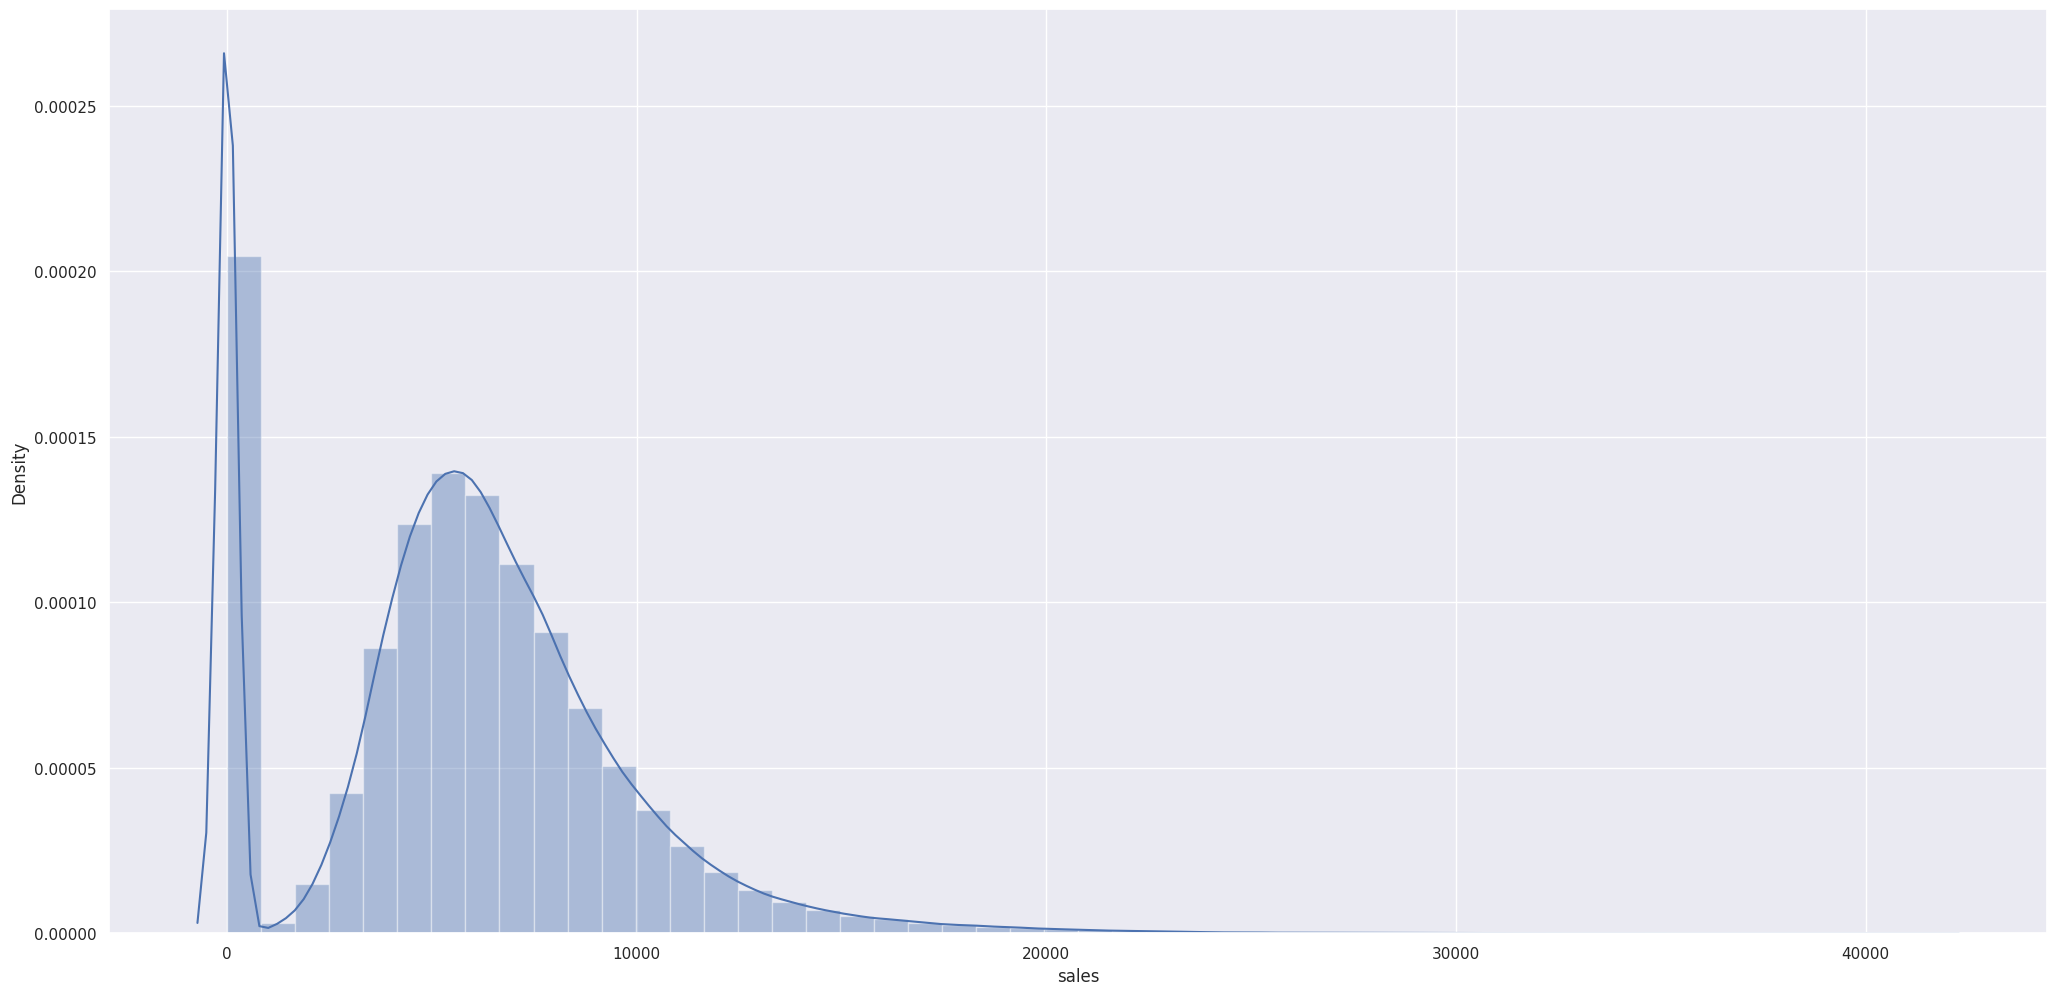

In [26]:
sns.distplot(df1['sales'])

<Axes: xlabel='competition_distance', ylabel='Density'>

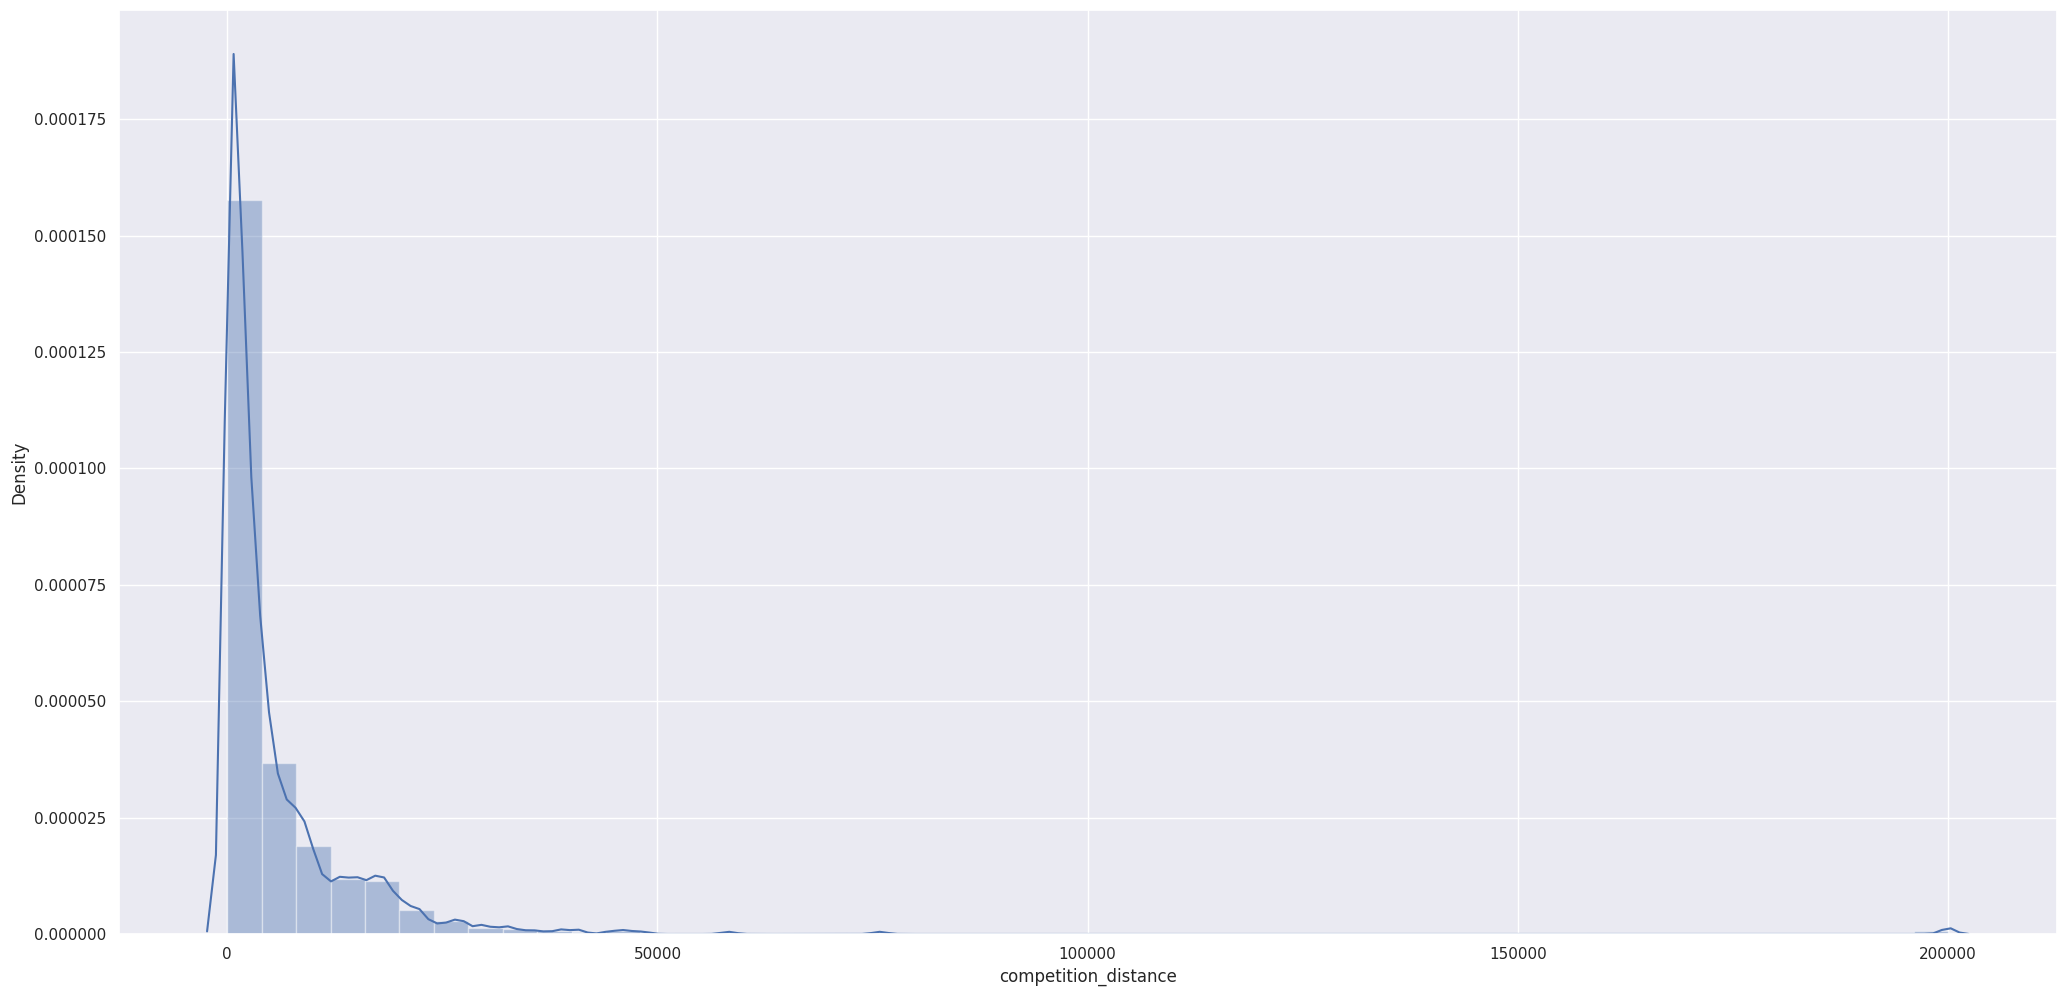

In [27]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Cattegorical Attributes

In [28]:
cat_attributes.apply(lambda x: x.unique().shape[0])

,0
state_holiday,4
store_type,4
assortment,3
promo_interval,4
month_map,12


<Axes: xlabel='assortment', ylabel='sales'>

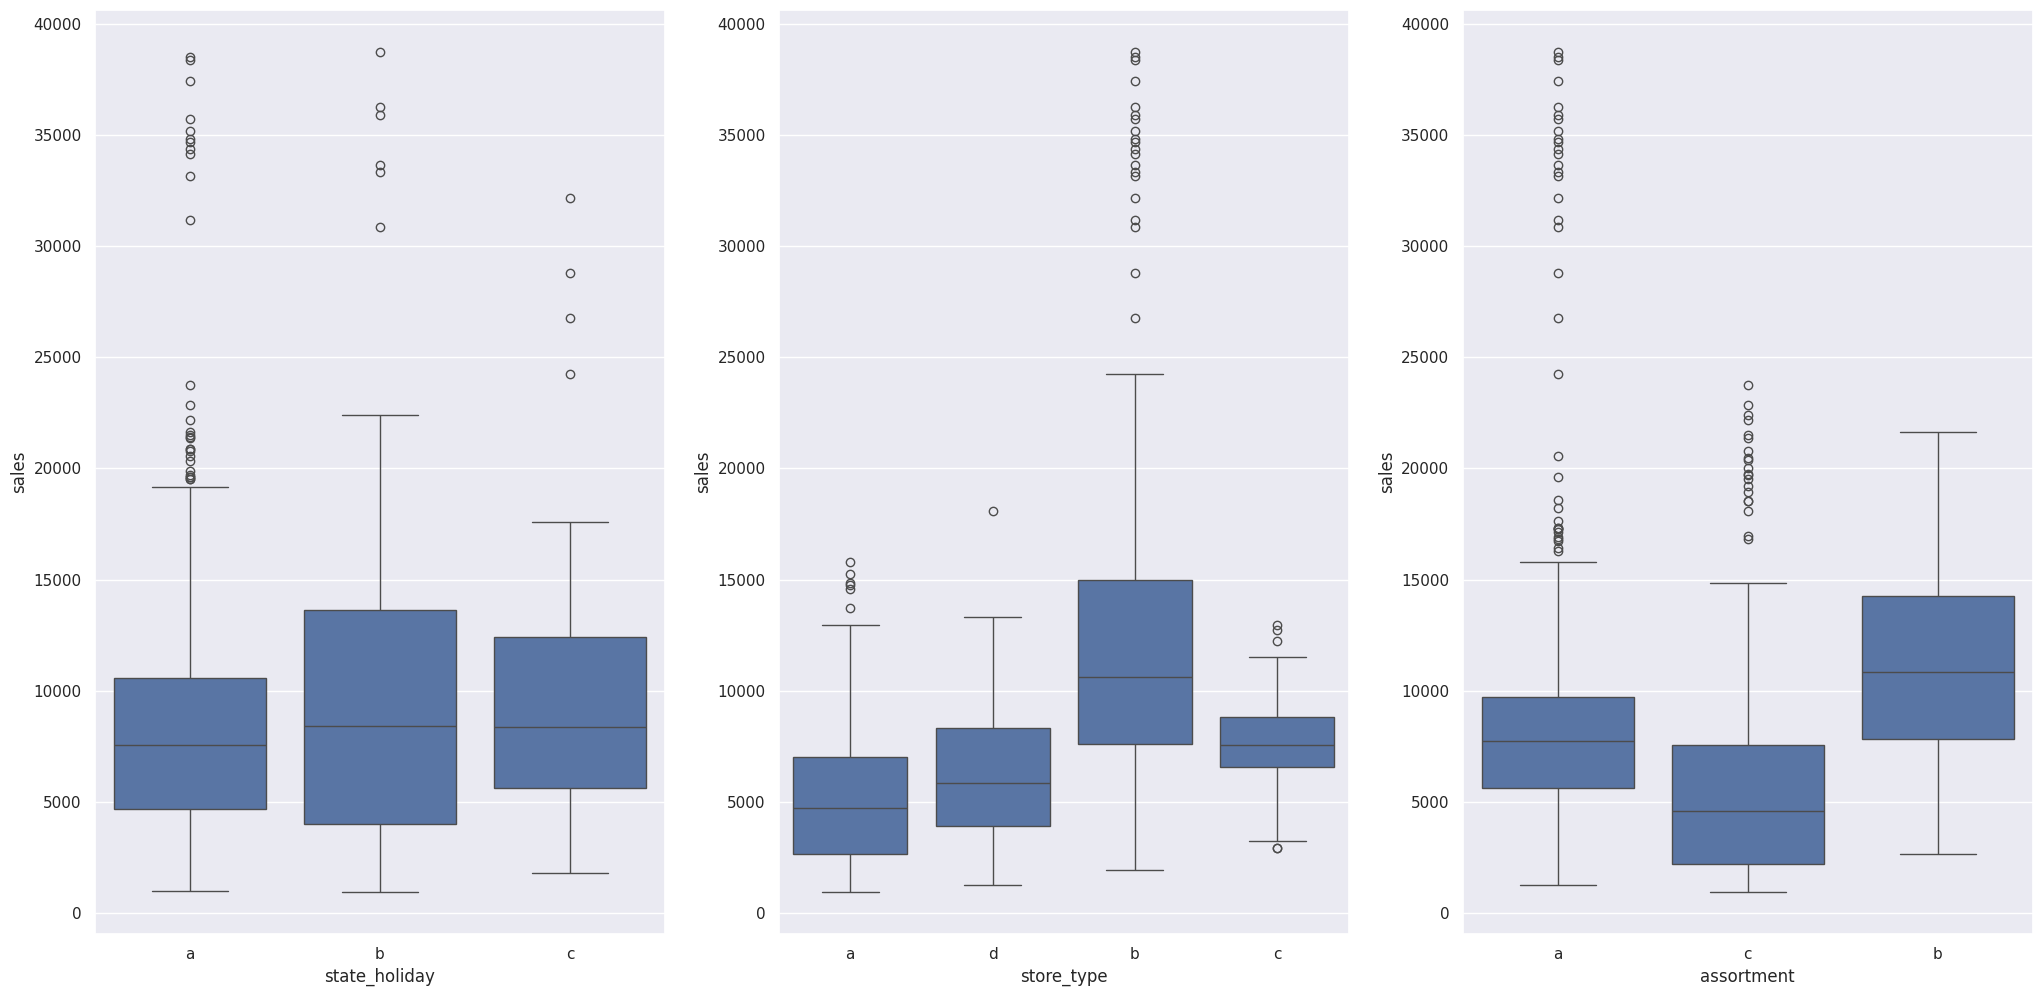

In [29]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot (1, 3, 1)
sns.boxplot( x='state_holiday', y= 'sales', data=aux1, legend=False)

plt.subplot(1, 3, 2)
sns.boxplot( x='store_type', y= 'sales', data=aux1, legend=False)

plt.subplot(1, 3, 3)
sns.boxplot( x='assortment', y= 'sales', data=aux1, legend=False)

# 2.0 Feature Engeneering

In [30]:
df2 = df1.copy()

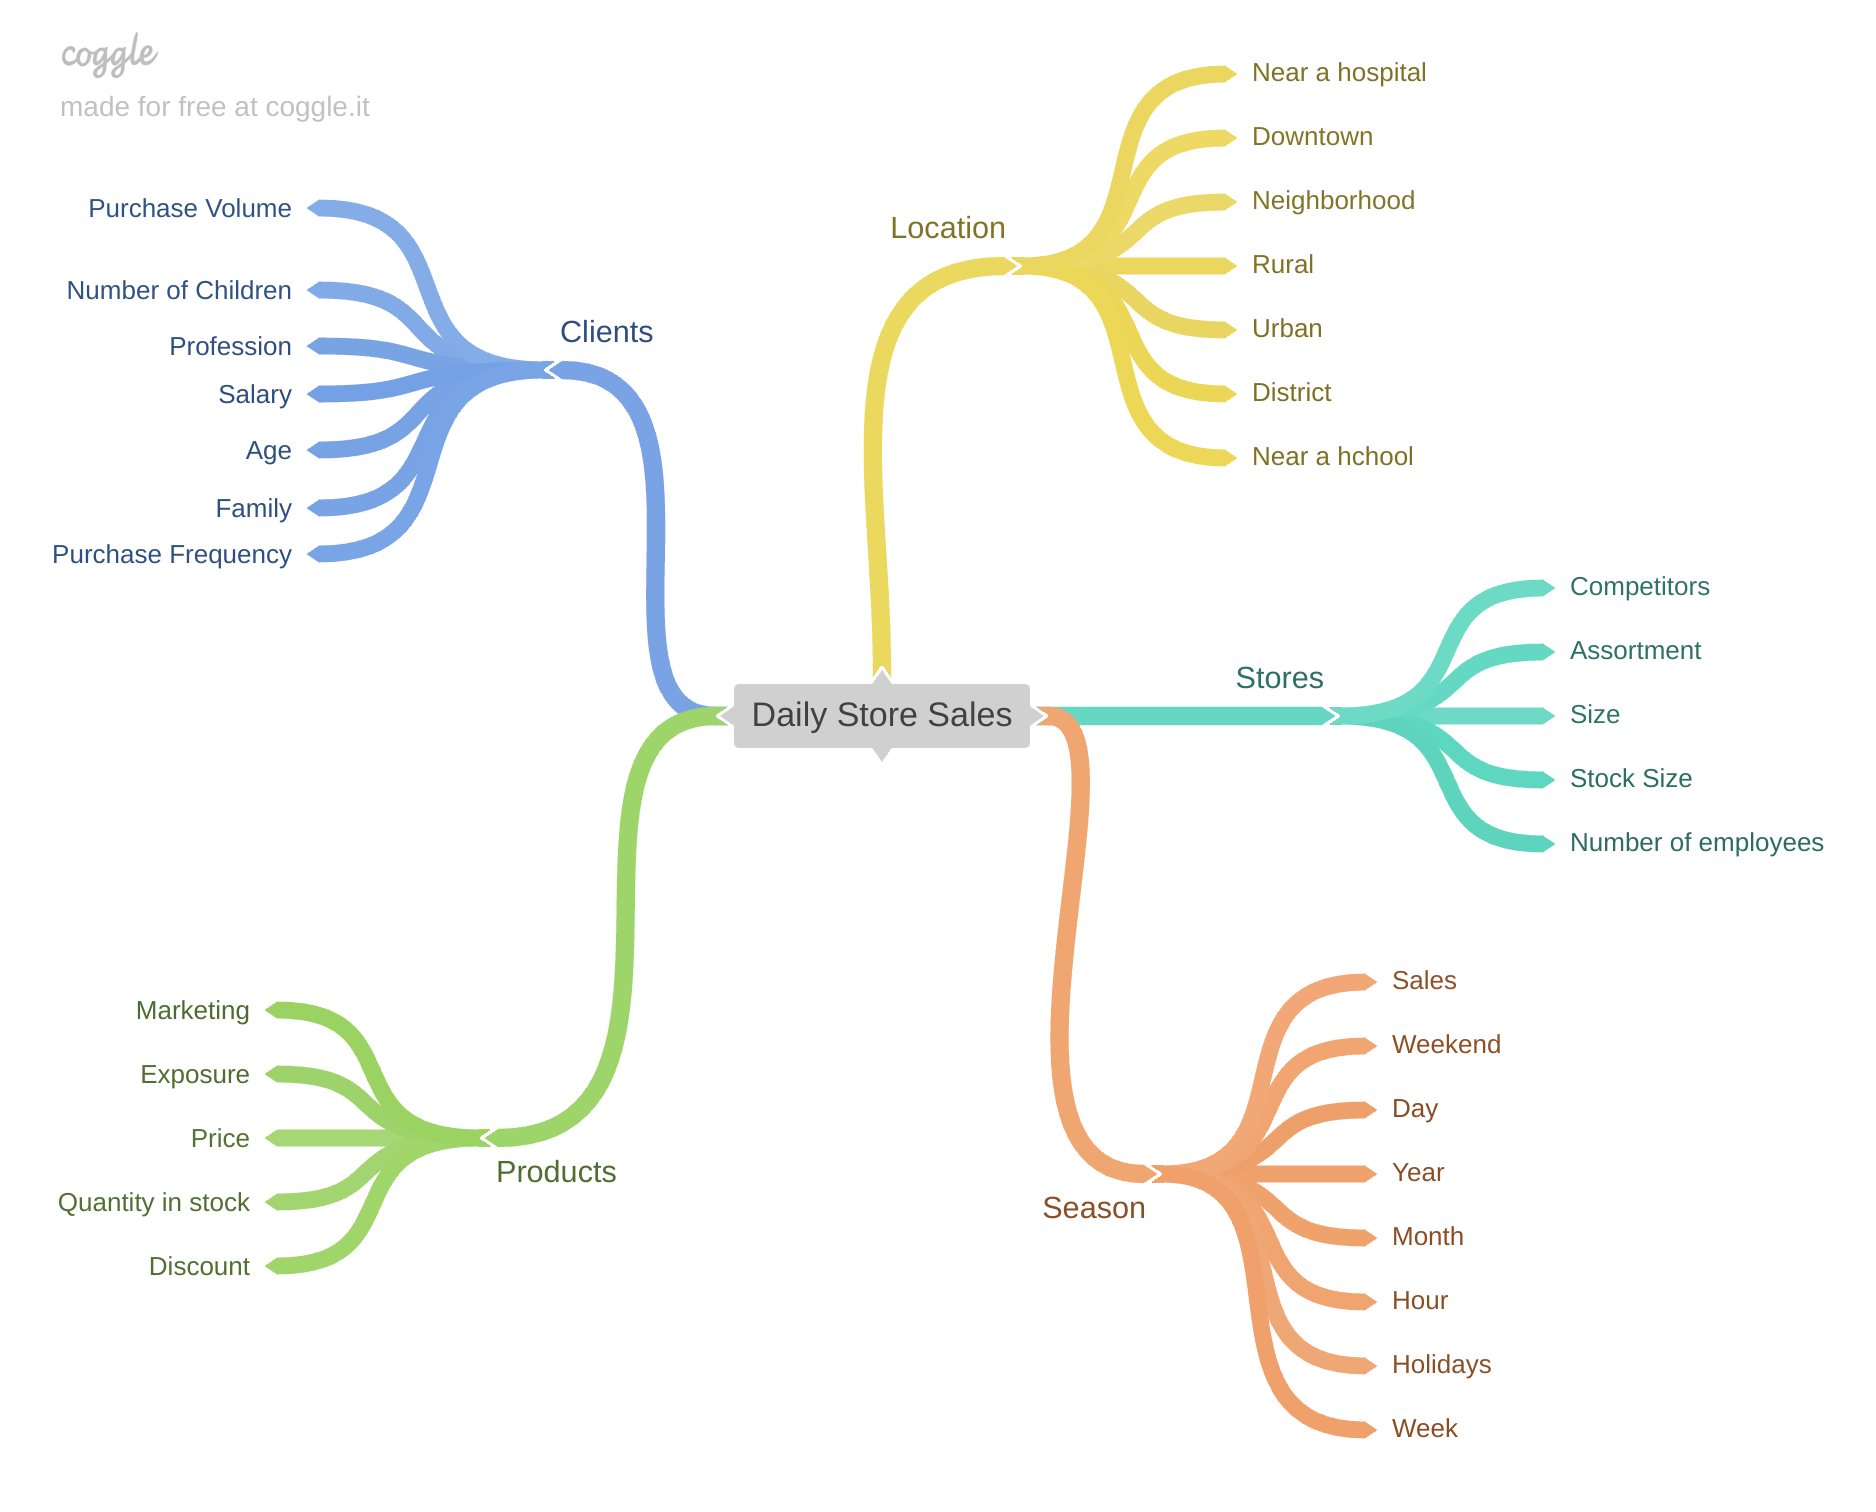

In [31]:
Image ('img/mind_map_hipotesis.png')

## 2.1 Criação de Hipoteses

### 2.1.1 Hipoteses Loja

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vender mais.

### 2.1.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expoe mais o produto nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais

**7.** Lojas qcom mais promoções consecutivas deveriam vender mais

### 2.1.3 Hipoteses Tempo (Sazonalidade)

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durantes os feriados escolares.

## 2.2 Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durantes os feriados escolares.

## 2.3 Feature Engeneering

In [32]:
# year

df2['year'] = df2['date'].dt.year

# month

df2['month'] = df2['date'].dt.month

# day

df2['day'] = df2['date'].dt.day

# week of year

df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year of week

df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since

df2['competition_since'] = df2.apply(lambda x: datetime.datetime ( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1) , axis= 1)
df2['competition_time_month'] = ((df2['date'] - df2[ 'competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since

df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days).astype(int)

# assortment

df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended')

# state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

In [33]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtragem de Variáveis

In [34]:
df3 = df2.copy()

In [35]:
df3.shape

(1017209, 29)

## 3.1 Filtragem das linhas

In [36]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Seleção das Colunas

In [37]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis=1)

In [38]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Análise Exploratória dos Dados

In [39]:
df4 = df3.copy()

## 4.1 Análise Univariada

### 4.1.1 Response Variable

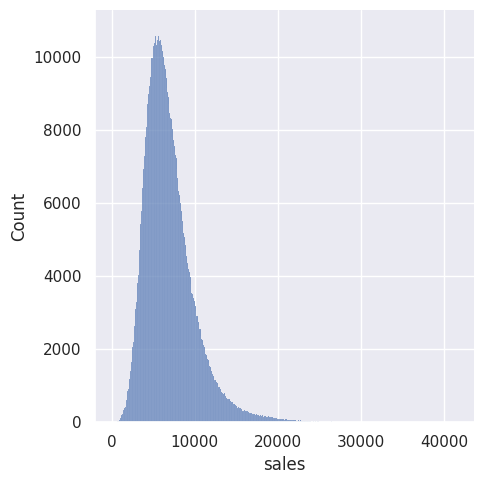

In [40]:
sns.displot (df4['sales'], kde=False)

### 4.1.2 Numerical Variables

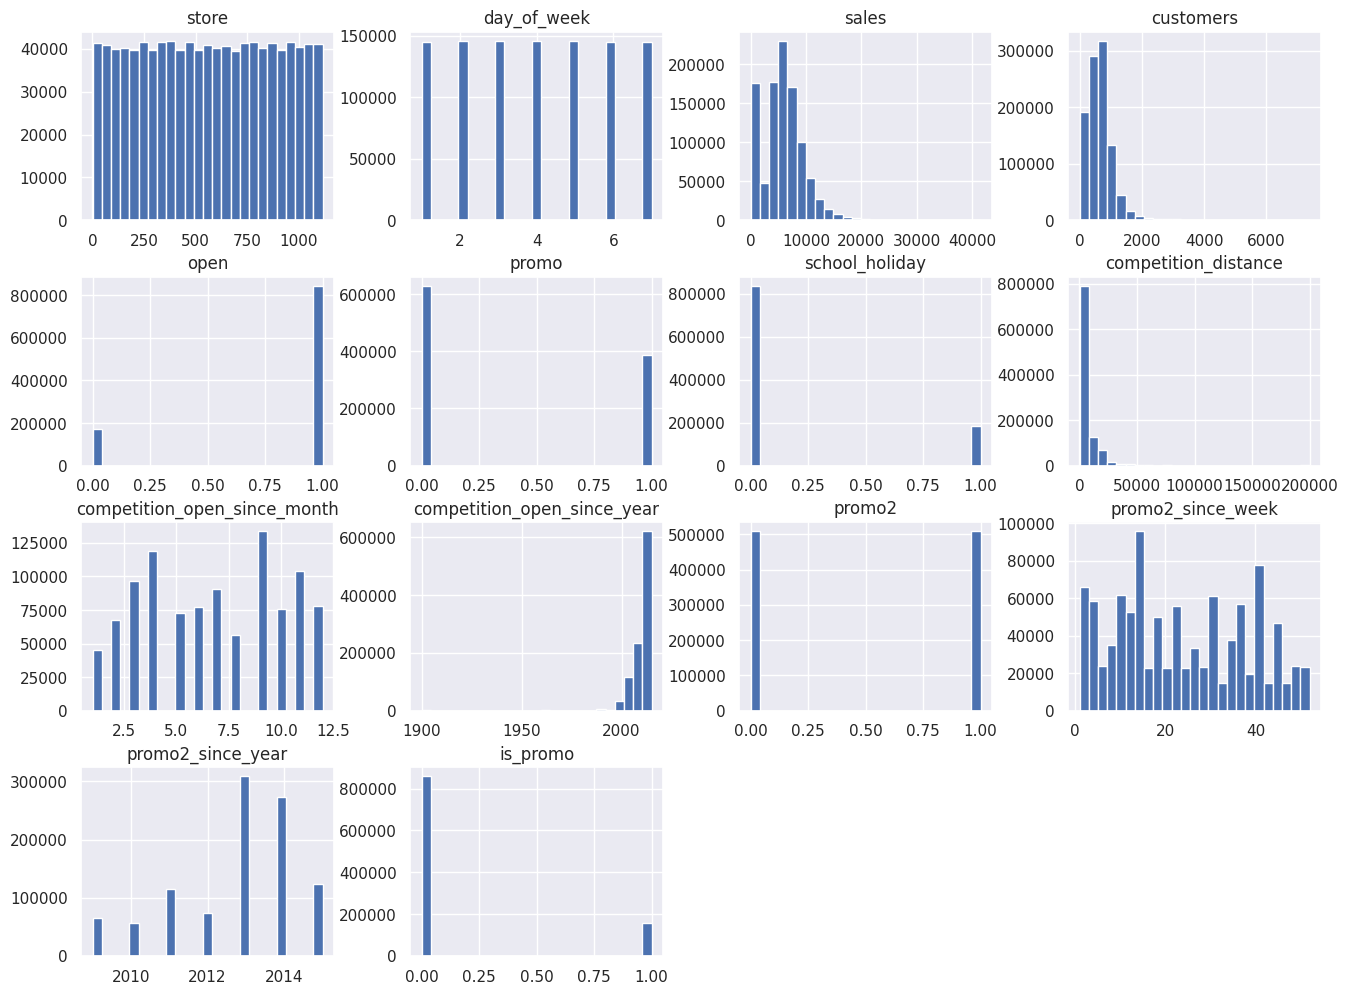

In [41]:
num_attributes.hist(bins= 25, figsize=(16,12));

### 4.1.3 Categorical Variable

In [42]:
df4['state_holiday'].drop_duplicates()

,state_holiday
0,regular_day
63559,public_holiday
129424,easter_holiday
241126,christmas


<Axes: xlabel='count', ylabel='state_holiday'>

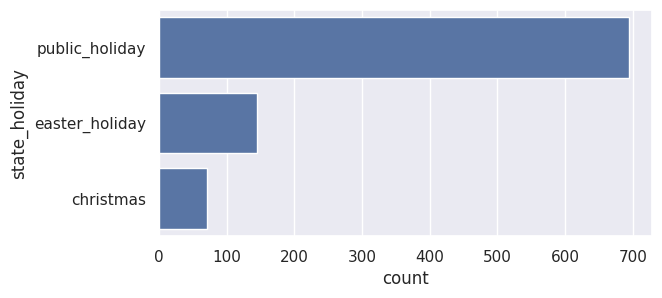

In [43]:
#state_holiday

plt.figure(figsize=(14,10))
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']

sns.countplot (a['state_holiday'])

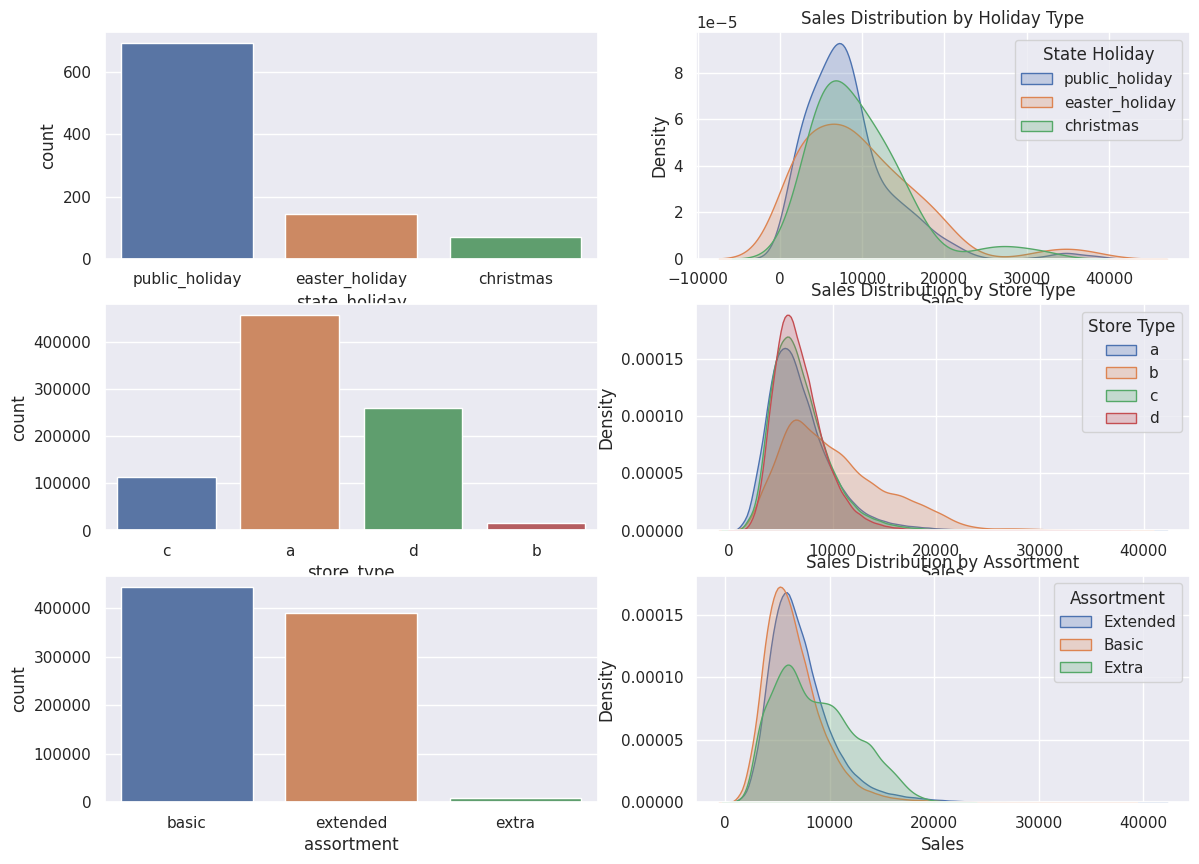

In [44]:
#state_holiday

plt.figure(figsize=(14,10))
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']

sns.countplot (x=a['state_holiday'], hue=a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(x=df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)

sns.kdeplot(x=df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True)

sns.kdeplot(x=df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True)
plt.xlabel("Sales")
plt.ylabel("Density")
plt.title("Sales Distribution by Holiday Type")
plt.legend(title="State Holiday")

#store_type

plt.subplot(3,2,3)
sns.countplot (x=df4['store_type'], hue=df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(x=df4[df4['store_type'] == 'a']['sales'], label='a', fill=True)

sns.kdeplot(x=df4[df4['store_type'] == 'b']['sales'], label='b', fill=True)

sns.kdeplot(x=df4[df4['store_type'] == 'c']['sales'], label='c', fill=True)

sns.kdeplot(x=df4[df4['store_type'] == 'd']['sales'], label='d', fill=True)
plt.xlabel("Sales")
plt.ylabel("Density")
plt.title("Sales Distribution by Store Type")
plt.legend(title="Store Type")

#assortment

plt.subplot(3,2,5)
sns.countplot (x=df4['assortment'], hue=df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(x=df4[df4['assortment'] == 'extended']['sales'], label='Extended', fill=True)

sns.kdeplot(x=df4[df4['assortment'] == 'basic']['sales'], label='Basic', fill=True)

sns.kdeplot(x=df4[df4['assortment'] == 'extra']['sales'], label='Extra', fill=True)

plt.xlabel("Sales")
plt.ylabel("Density")
plt.title("Sales Distribution by Assortment")
plt.legend(title="Assortment")


In [45]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 4.2 Análise Bivariada

<Axes: xlabel='year_week'>

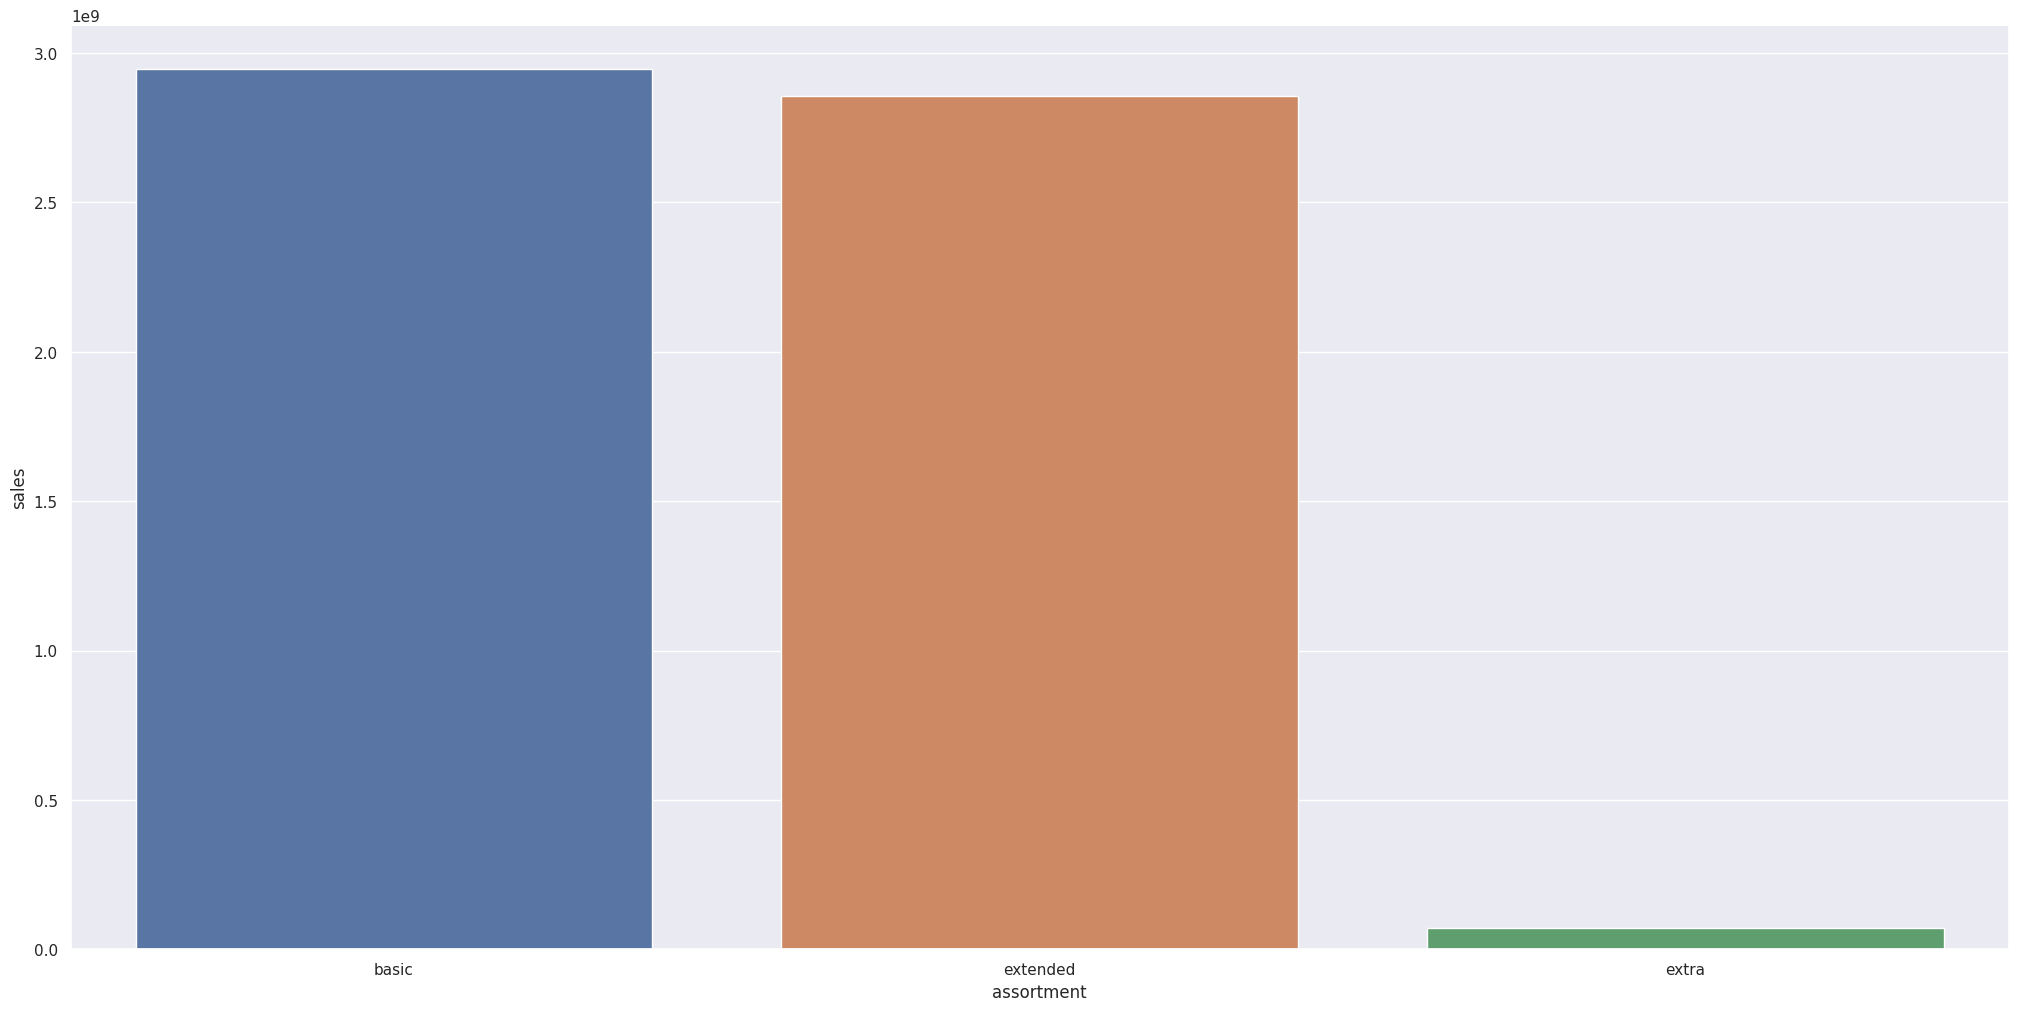

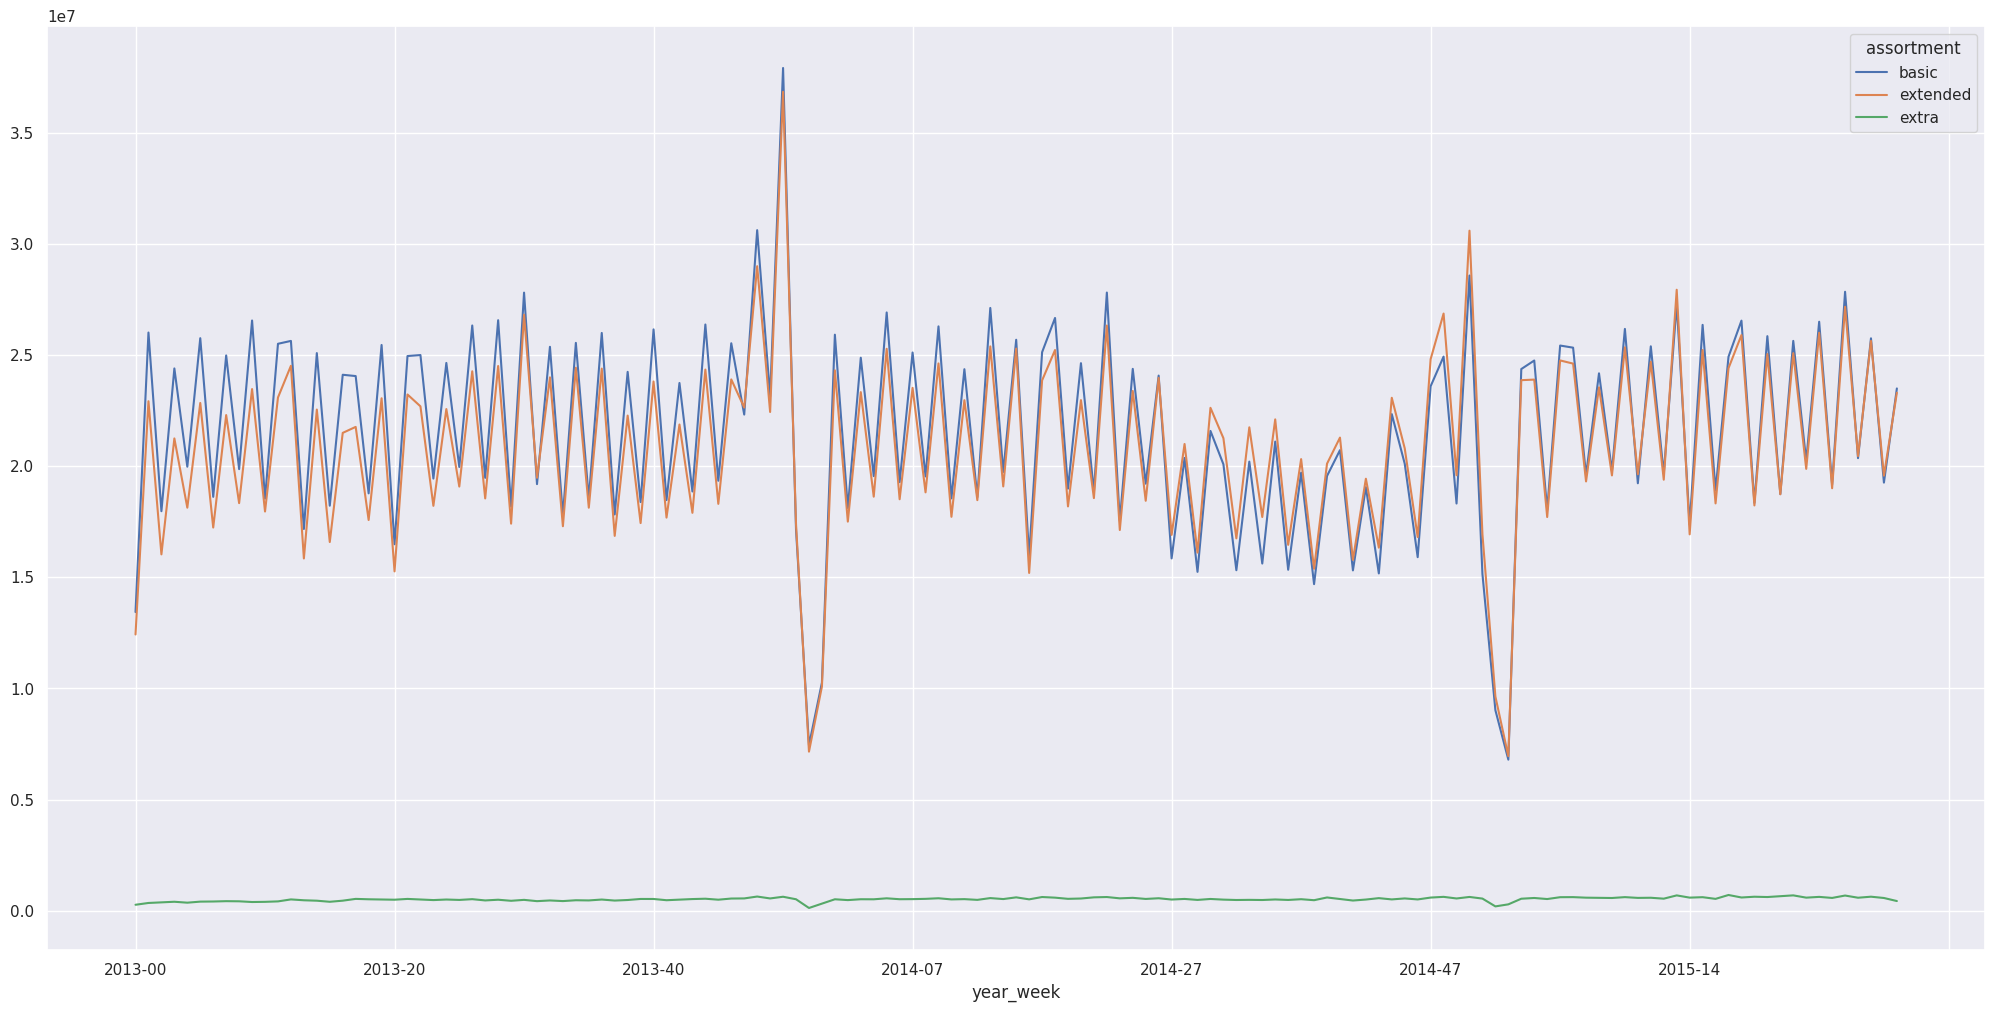

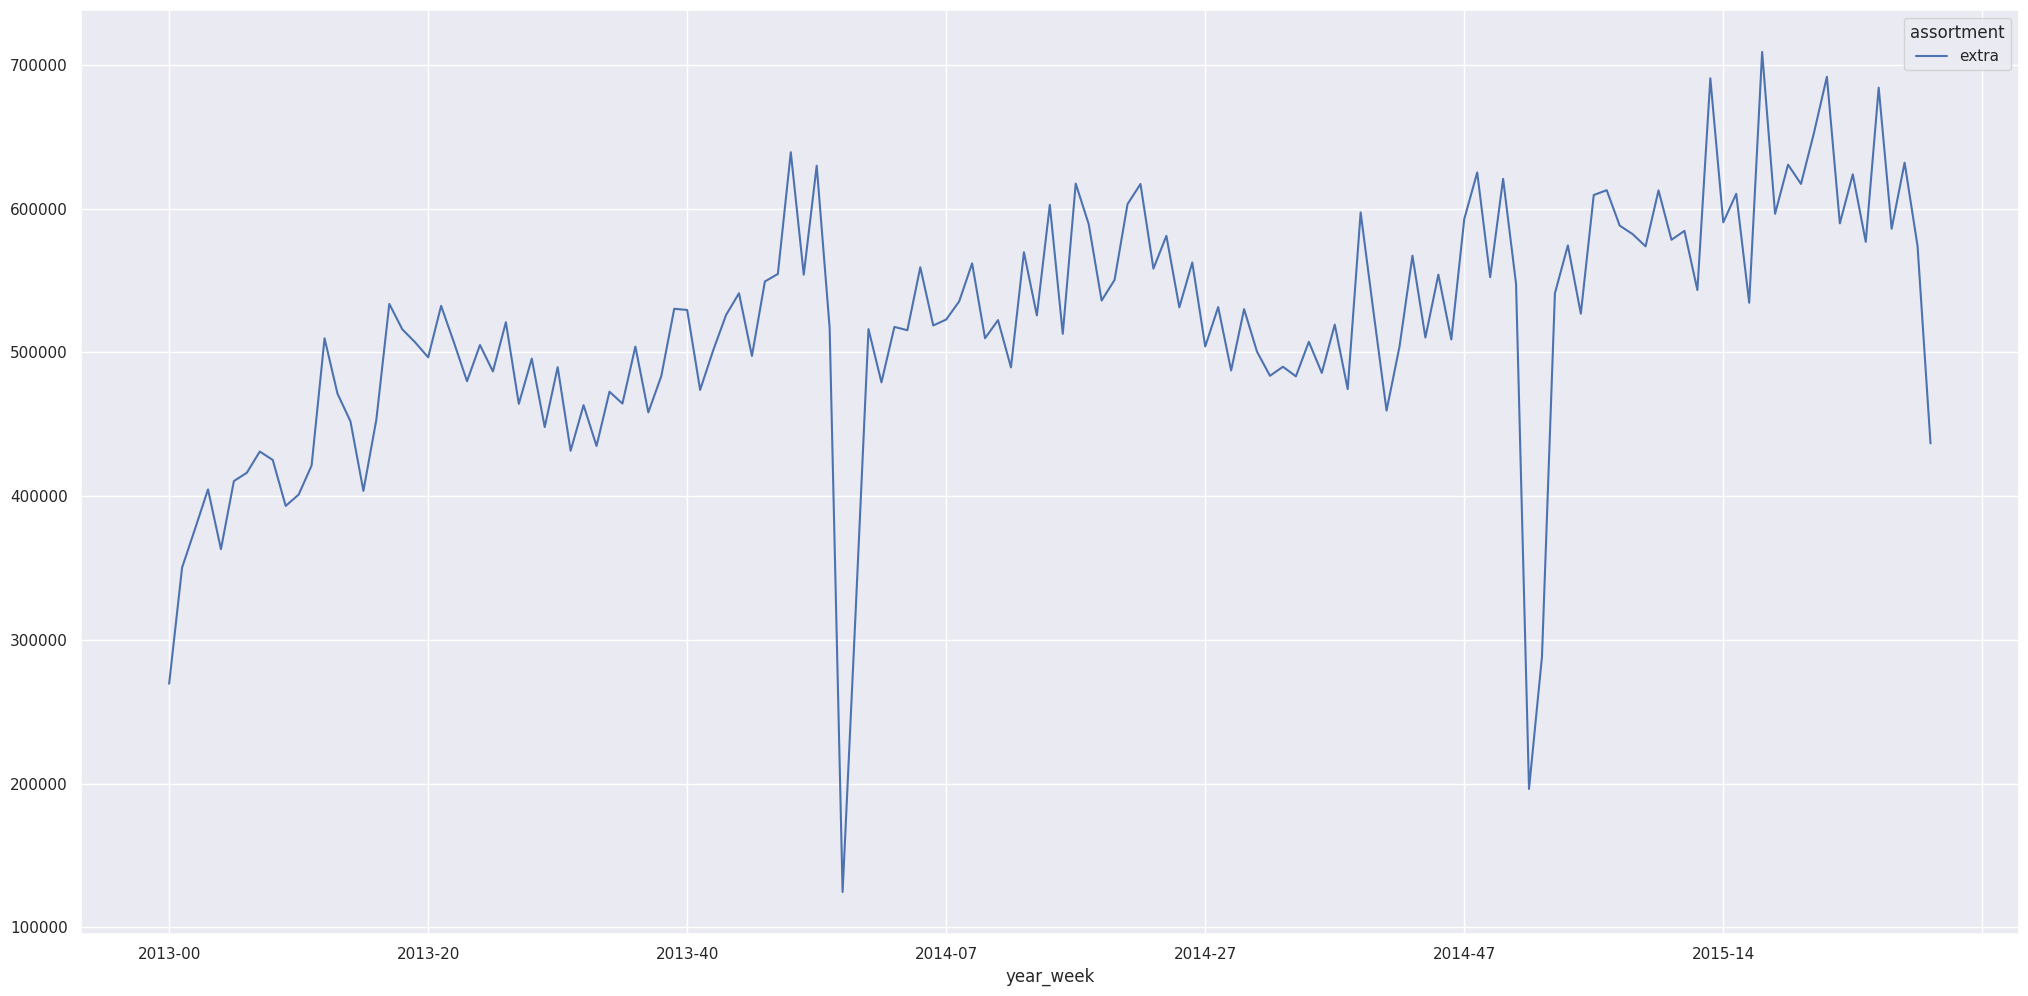

In [46]:
# Lojas com maior sortimento deveriam vender mais.
# Falsa - Lojas ocm maior sortimento vendem menos

aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()


sns.barplot( x='assortment', y='sales', data=aux1, hue='assortment')

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()



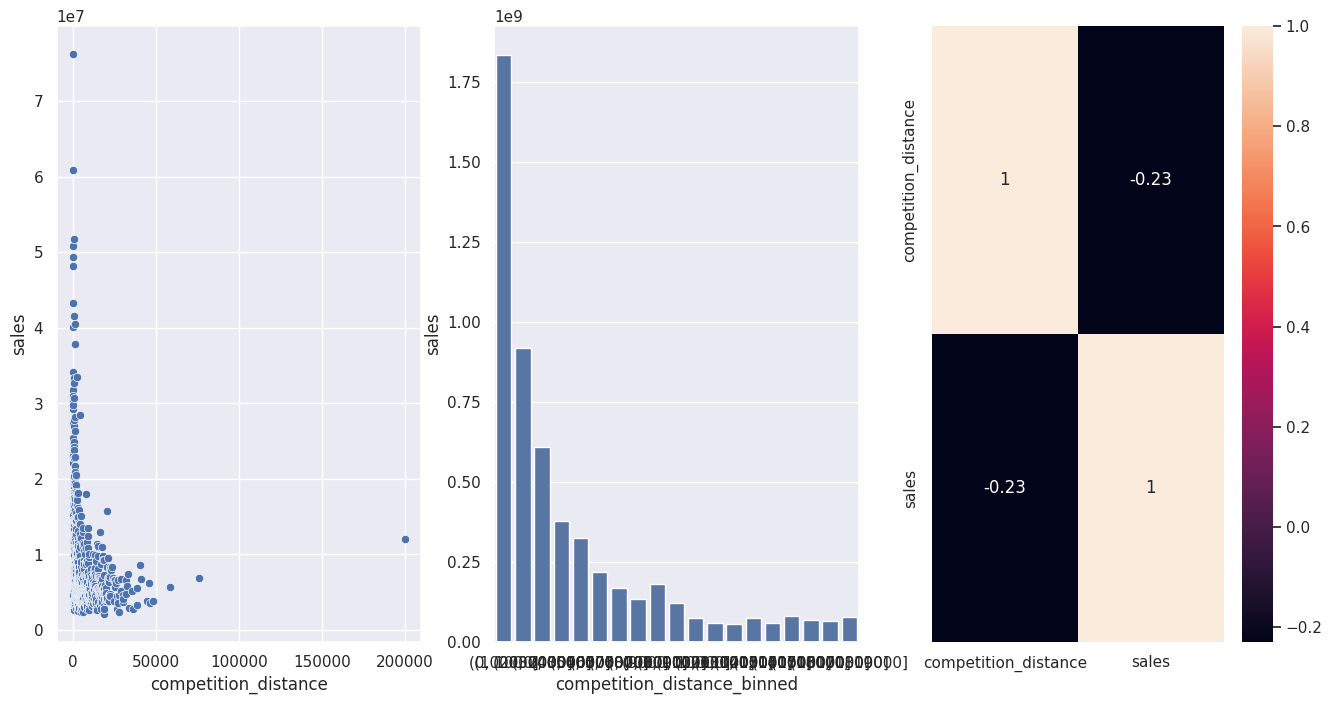

In [47]:
# Lojas com competidores mais próximos deveriam vender menos
# Falsa Loja com competidores MAIS proximos vendem MAIS

aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y='sales', data=aux1);

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);



plt.subplot(1,3,3)
aux3 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()
sns.heatmap(aux3.corr(method='pearson'), annot=True);



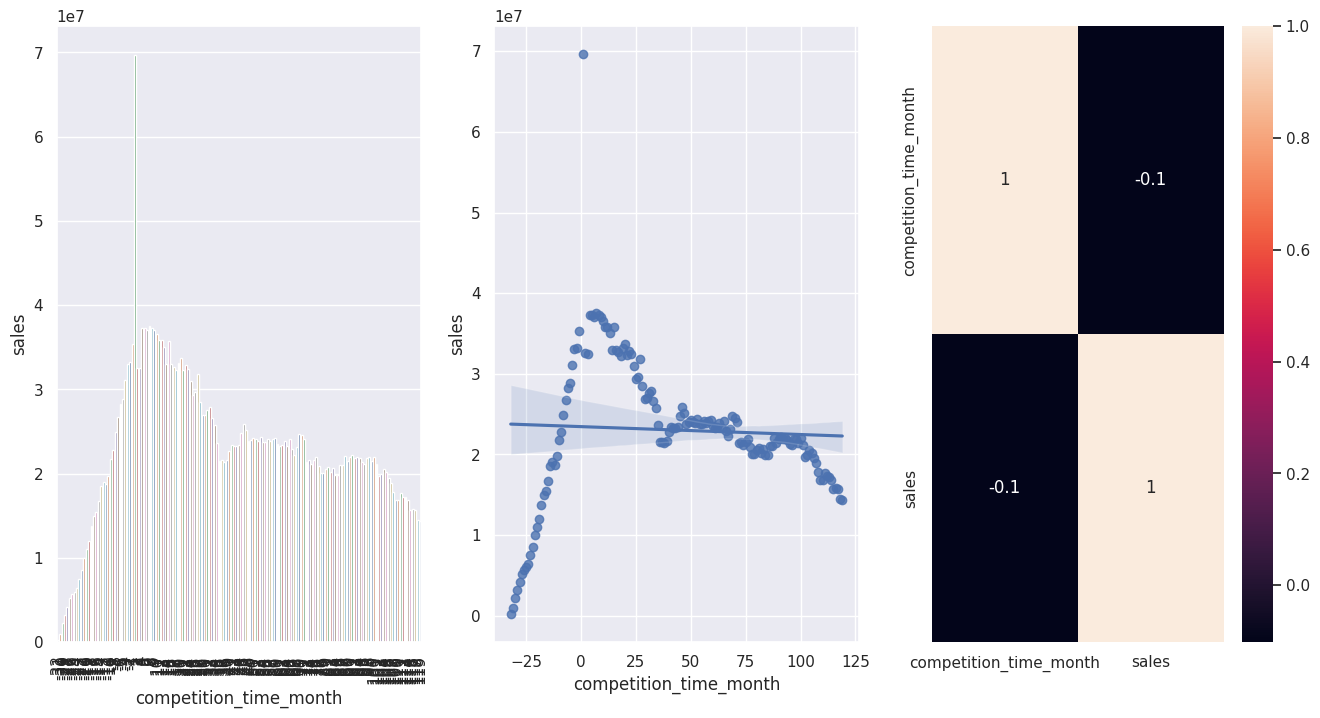

In [48]:
#Lojas com competidores a mais tempo deveria vender mais
# Falsa Lojas com competidores à mais tempo vendem MENOS

plt.figure(figsize=(16,8))
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] !=0)]
sns.barplot( x='competition_time_month', y = 'sales', data=aux2, hue='competition_time_month', legend=False, palette='deep')
plt.xticks(rotation=90);


plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2)

plt.subplot(1,3,3)
x = sns.heatmap( aux1.corr(method='pearson'), annot=True)


<Axes: >

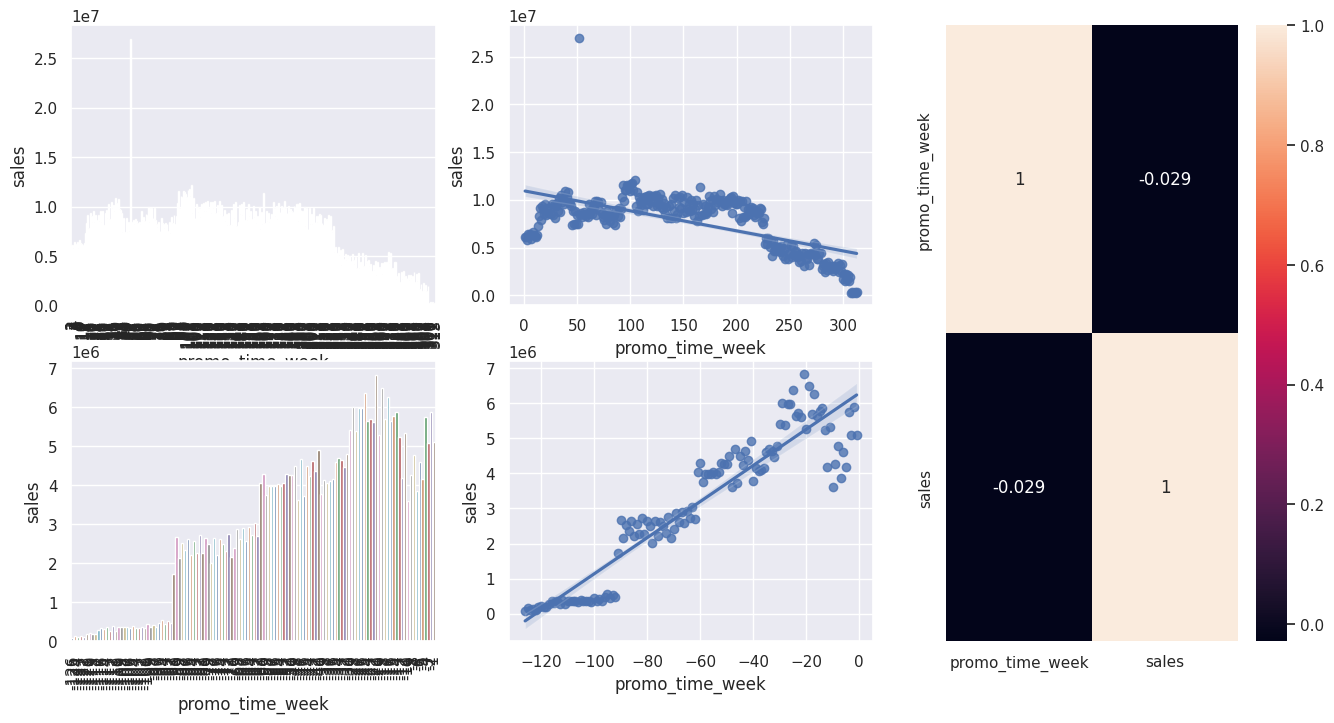

In [49]:
# Lojas com promoções ativas por mais tempo deveriam vender mais.
# FALSA - Lojas com promoçoes ativas por mais tempo vendem menos, depois de um certo periodo de promoção
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()


grid = GridSpec (2,3)
plt.figure(figsize=(16,8))

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2, hue='promo_time_week', legend=False, palette='deep');
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot(x='promo_time_week', y='sales', data=aux3, hue='promo_time_week', legend=False, palette='deep');
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True)


In [50]:
# Lojas co mmais dias de promoção deveriam vender mais

In [51]:
# Lojas com mais promoções consecutivas deveriam vender mais.
#FALSA - Lojas com mais promoções consecutivas vendem MENOS
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


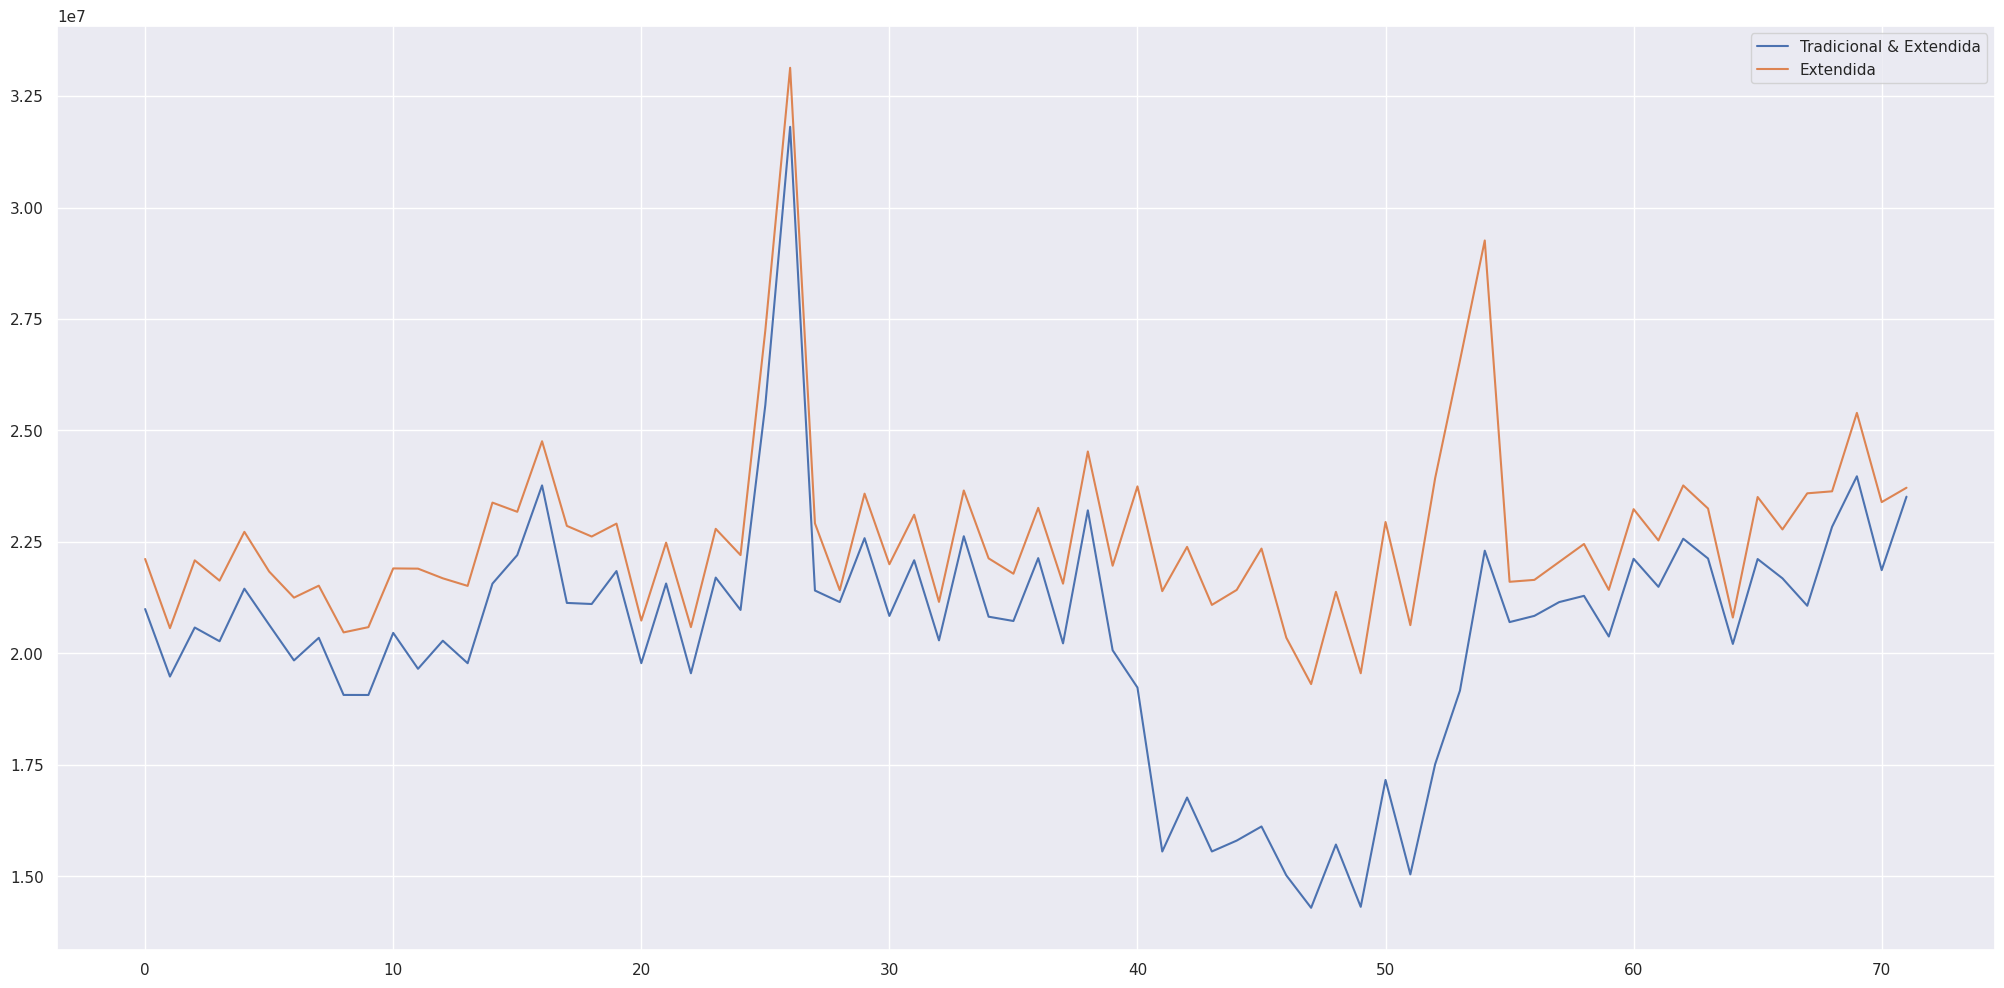

In [52]:
aux1= df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax= aux1.plot()

aux2= df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida'])

<Axes: xlabel='year', ylabel='sales'>

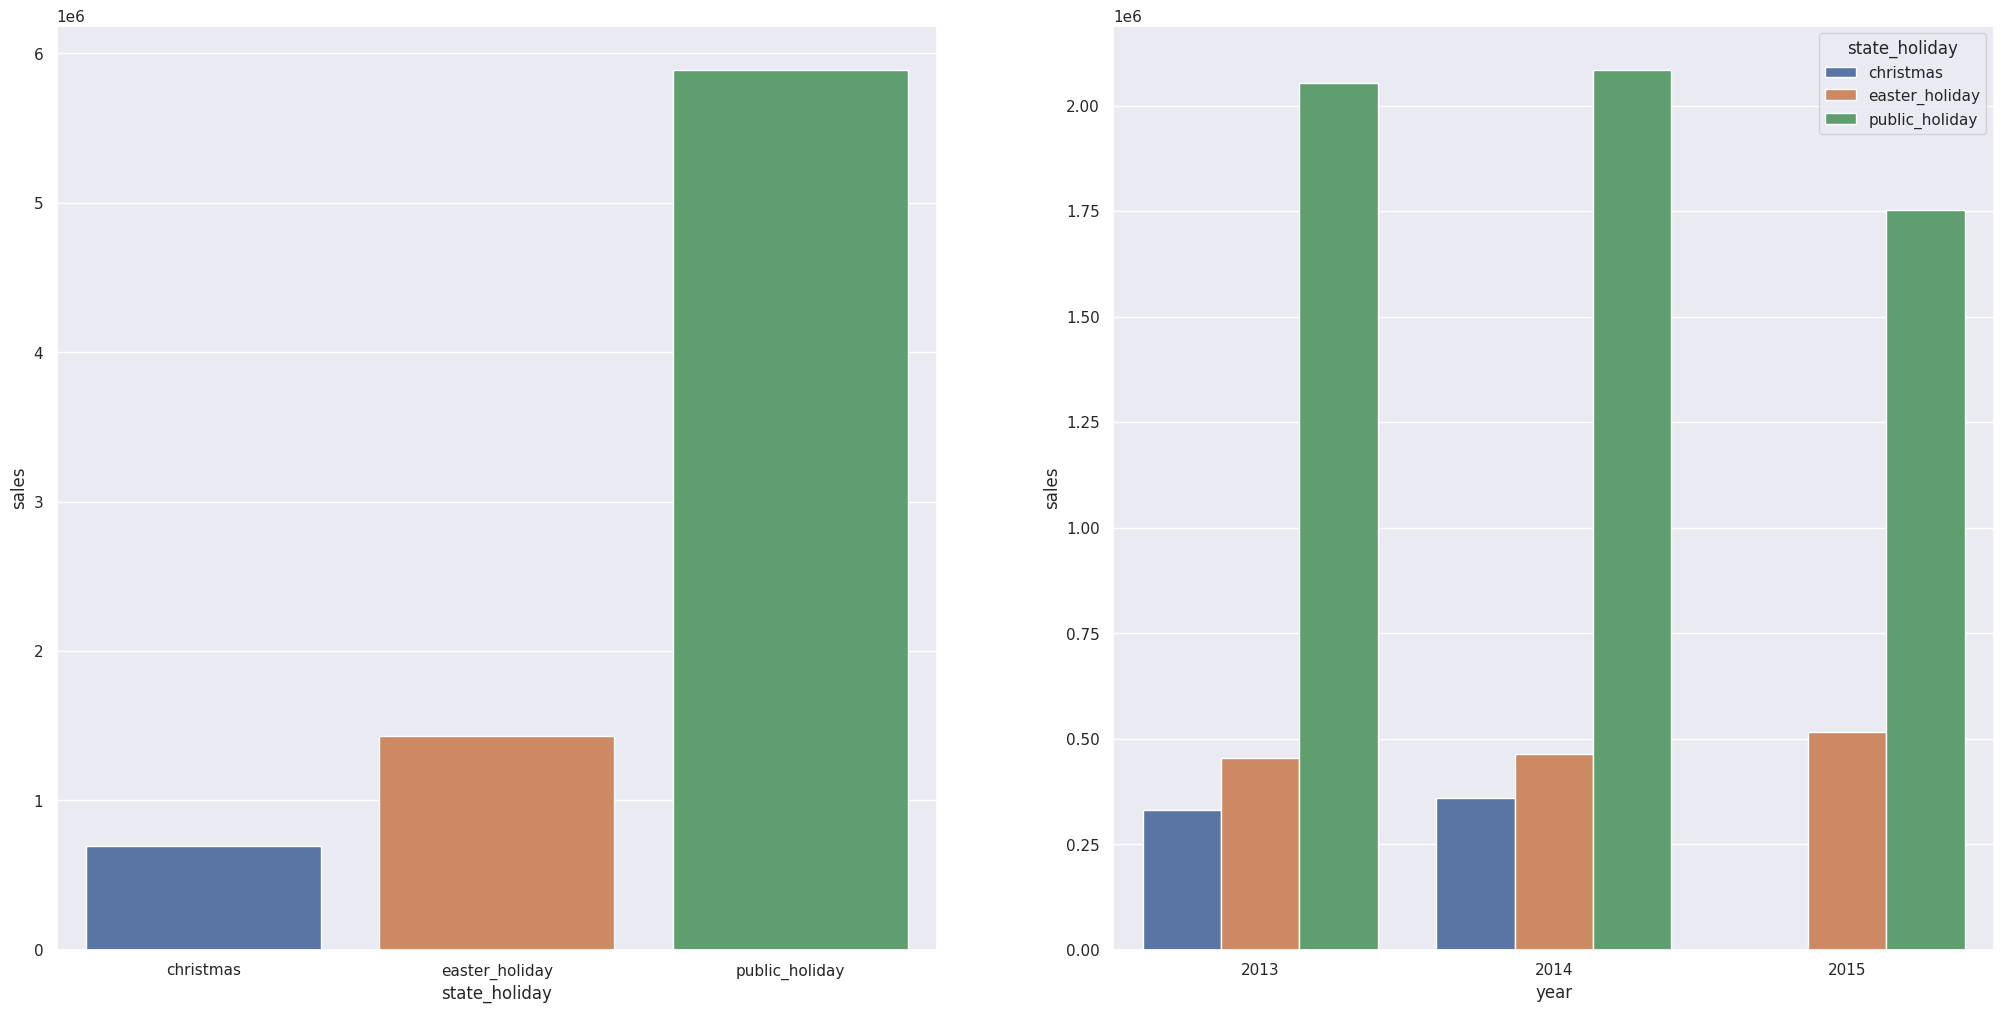

In [53]:
# Lojas abertas durante o feriado de Natal deveriam vender mais.
#FALSA - Lojas abertas durante o feriado de Natal vendem MENOS
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1, hue='state_holiday');

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2)

<Axes: >

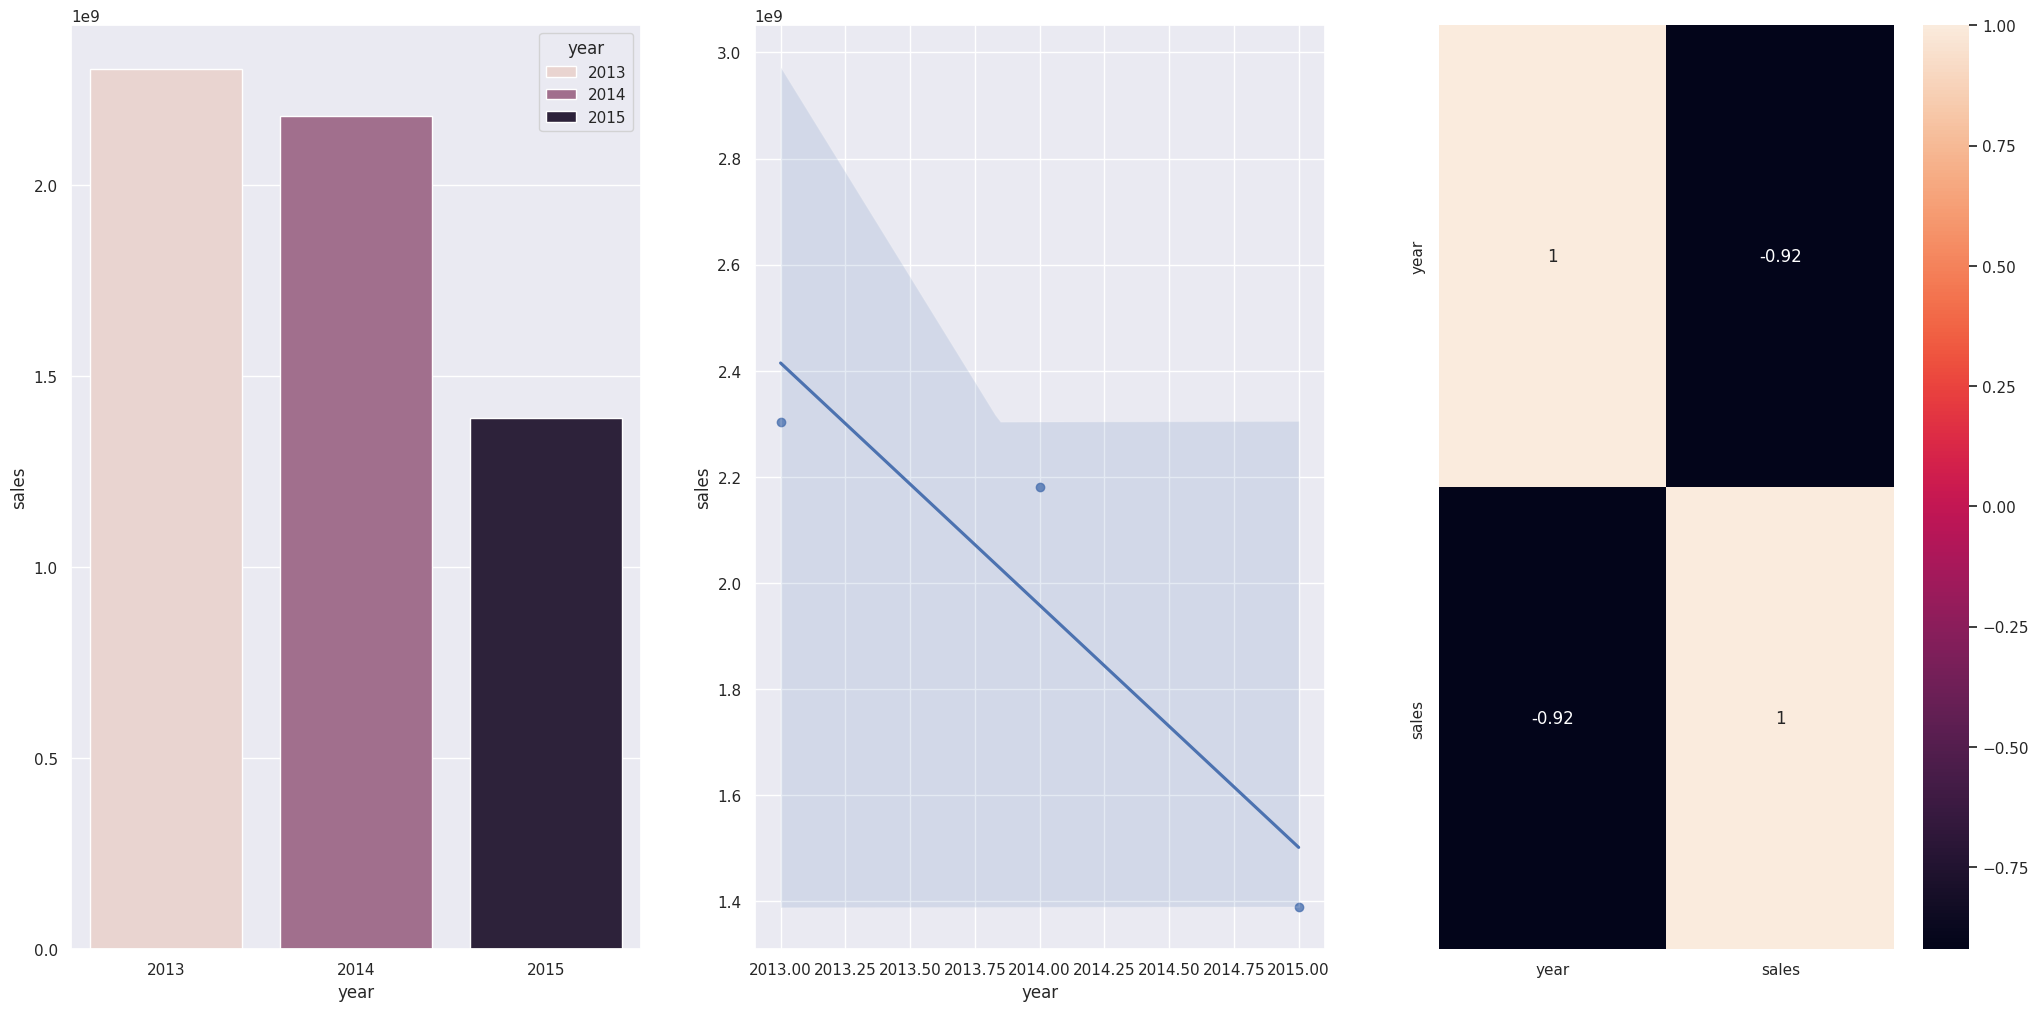

In [54]:
# Lojas deveriam vender mais ao longo dos anos
# FALSA - Lojas vendem MENOS ao longo dos anos

aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data= aux1, hue='year')

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data= aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

<Axes: >

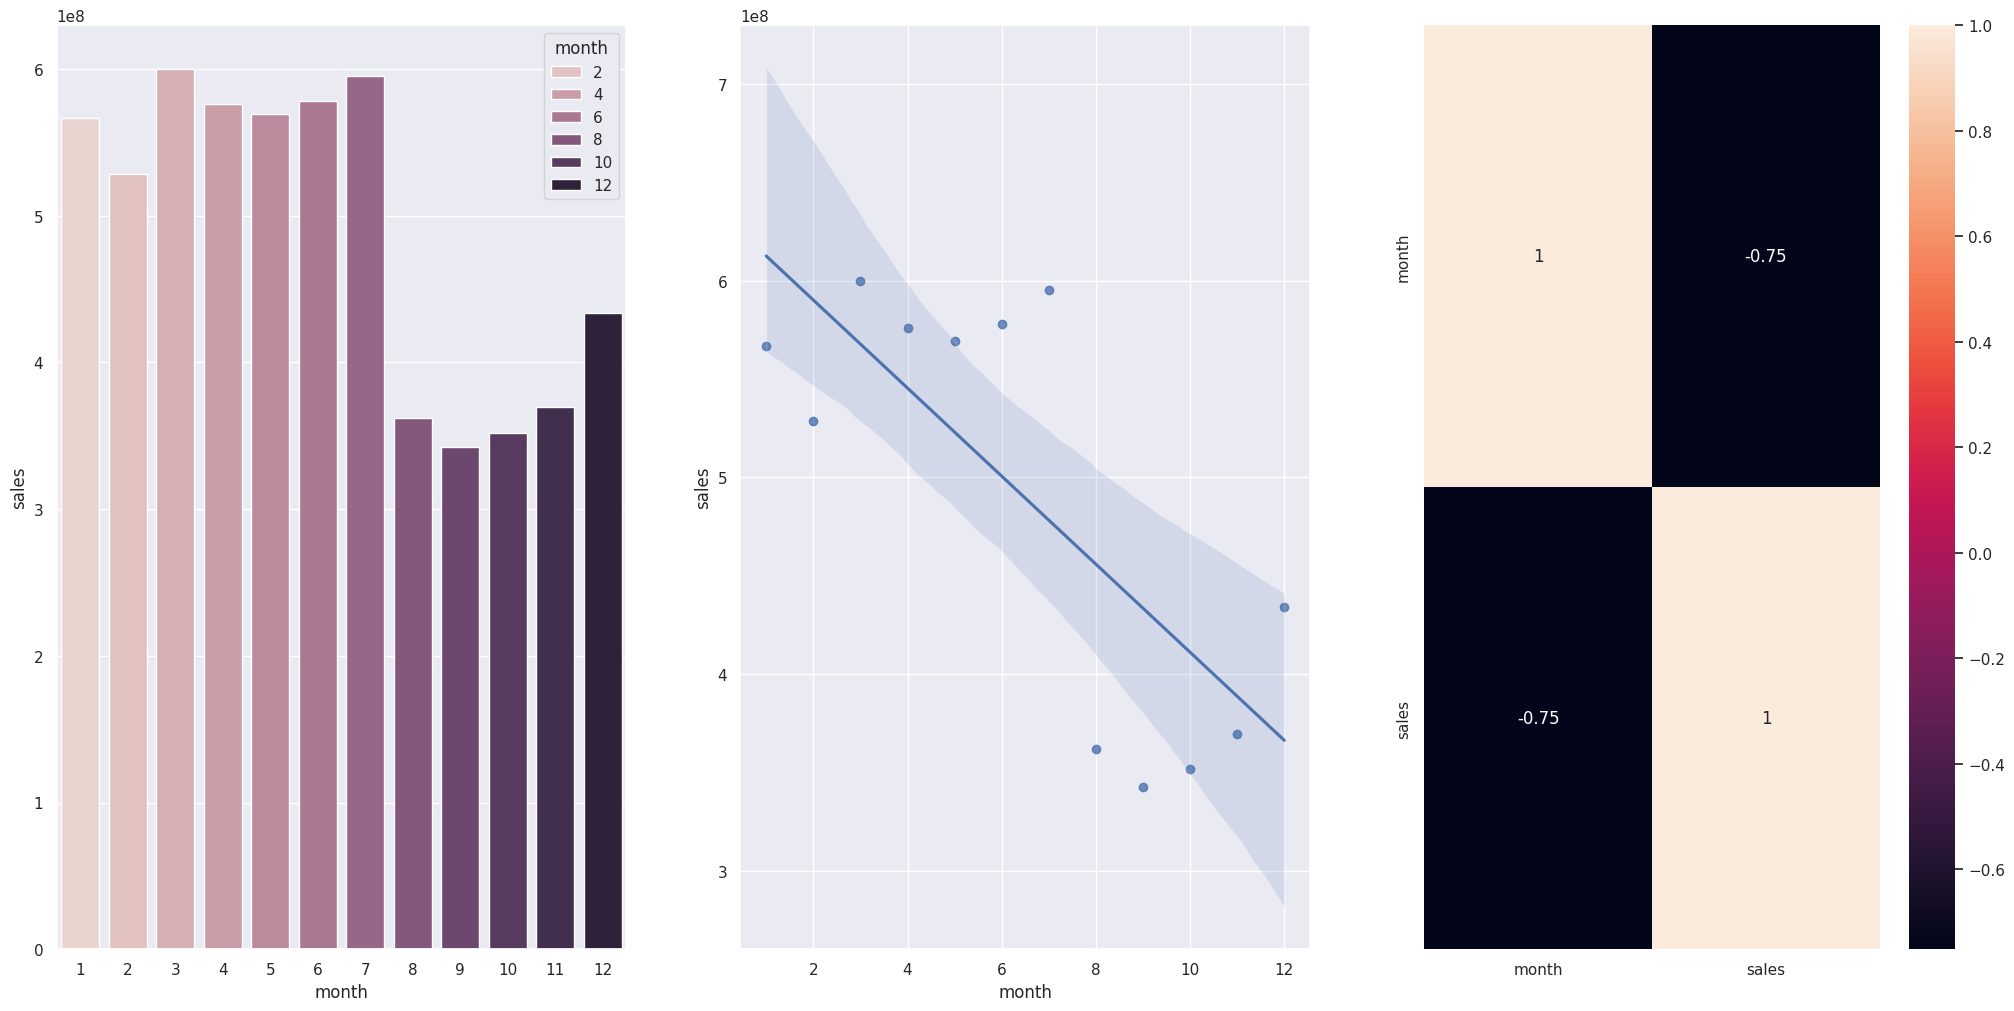

In [55]:
# Lojas deveriam vender mais no segundo semetre do ano
# Falsa - Lojas vendem MENOS no segundo semestre do ano

aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data= aux1, hue='month')

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data= aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

<Axes: xlabel='before_after', ylabel='sales'>

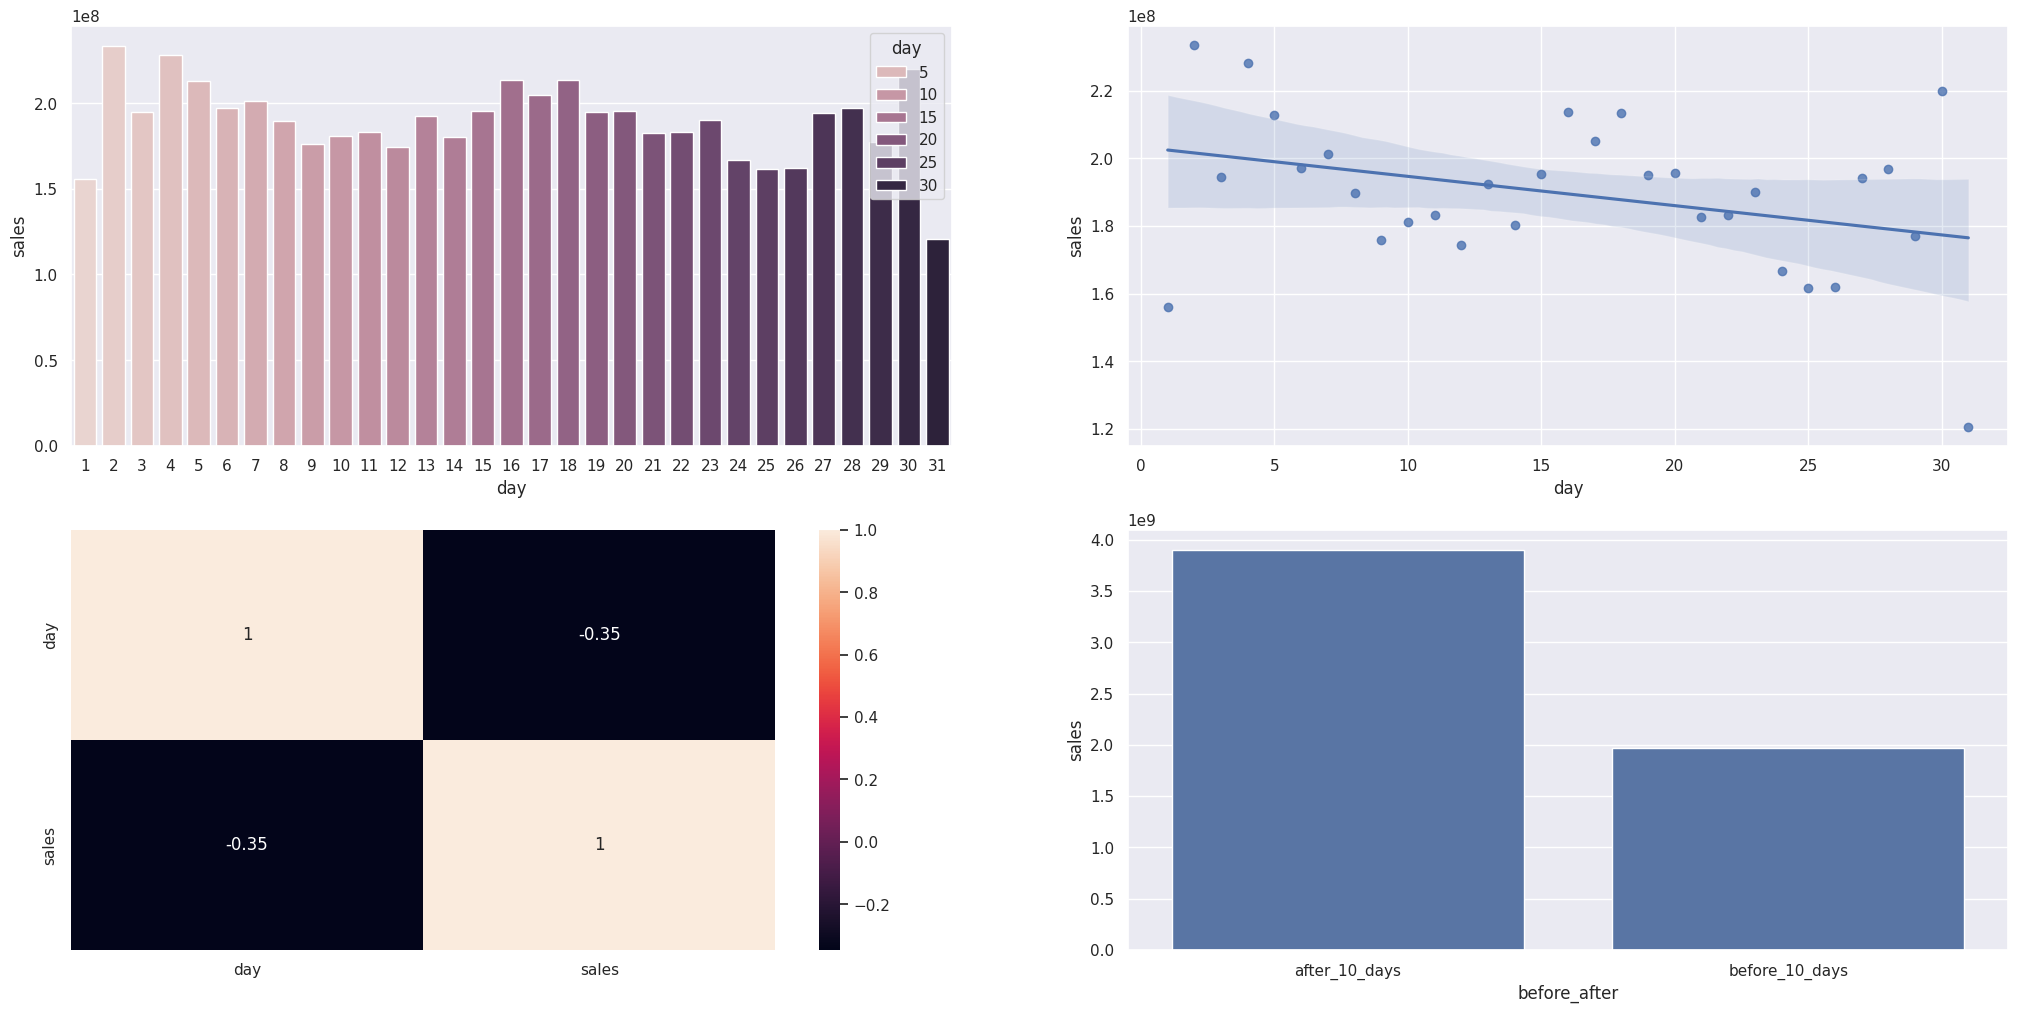

In [56]:
# Lojas deveriam vender mais depois do dia 10 de cada mes
# VERDADEIRA - Lojas vendem MAIS depois do dia 10 de cada mes

aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data= aux1, hue='day')

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data= aux1)

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2)


<Axes: >

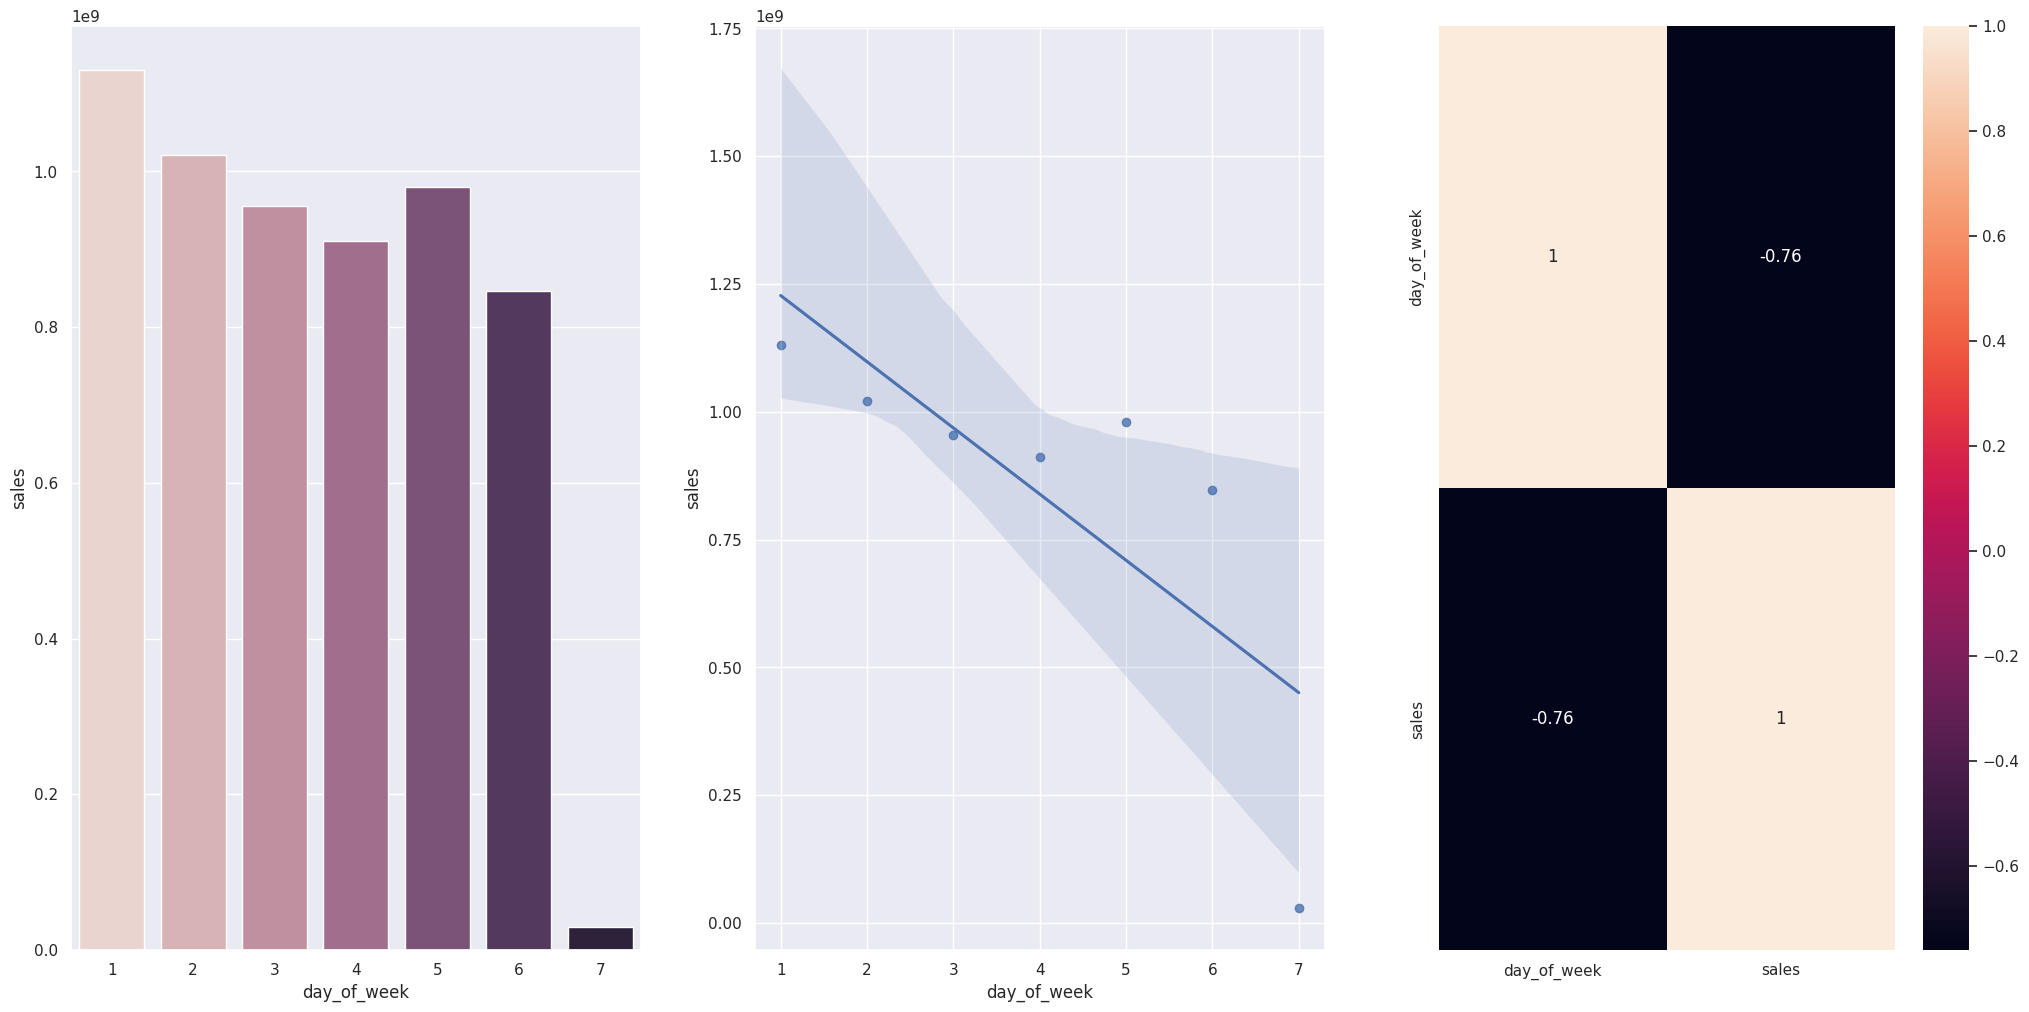

In [57]:
# Lojas deveriam vender menos aos finais de semana
# VERDADEIRA - Lojas vendem MENOS nos finais de semana

aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data= aux1, hue='day_of_week', legend=False)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data= aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

<Axes: xlabel='month', ylabel='sales'>

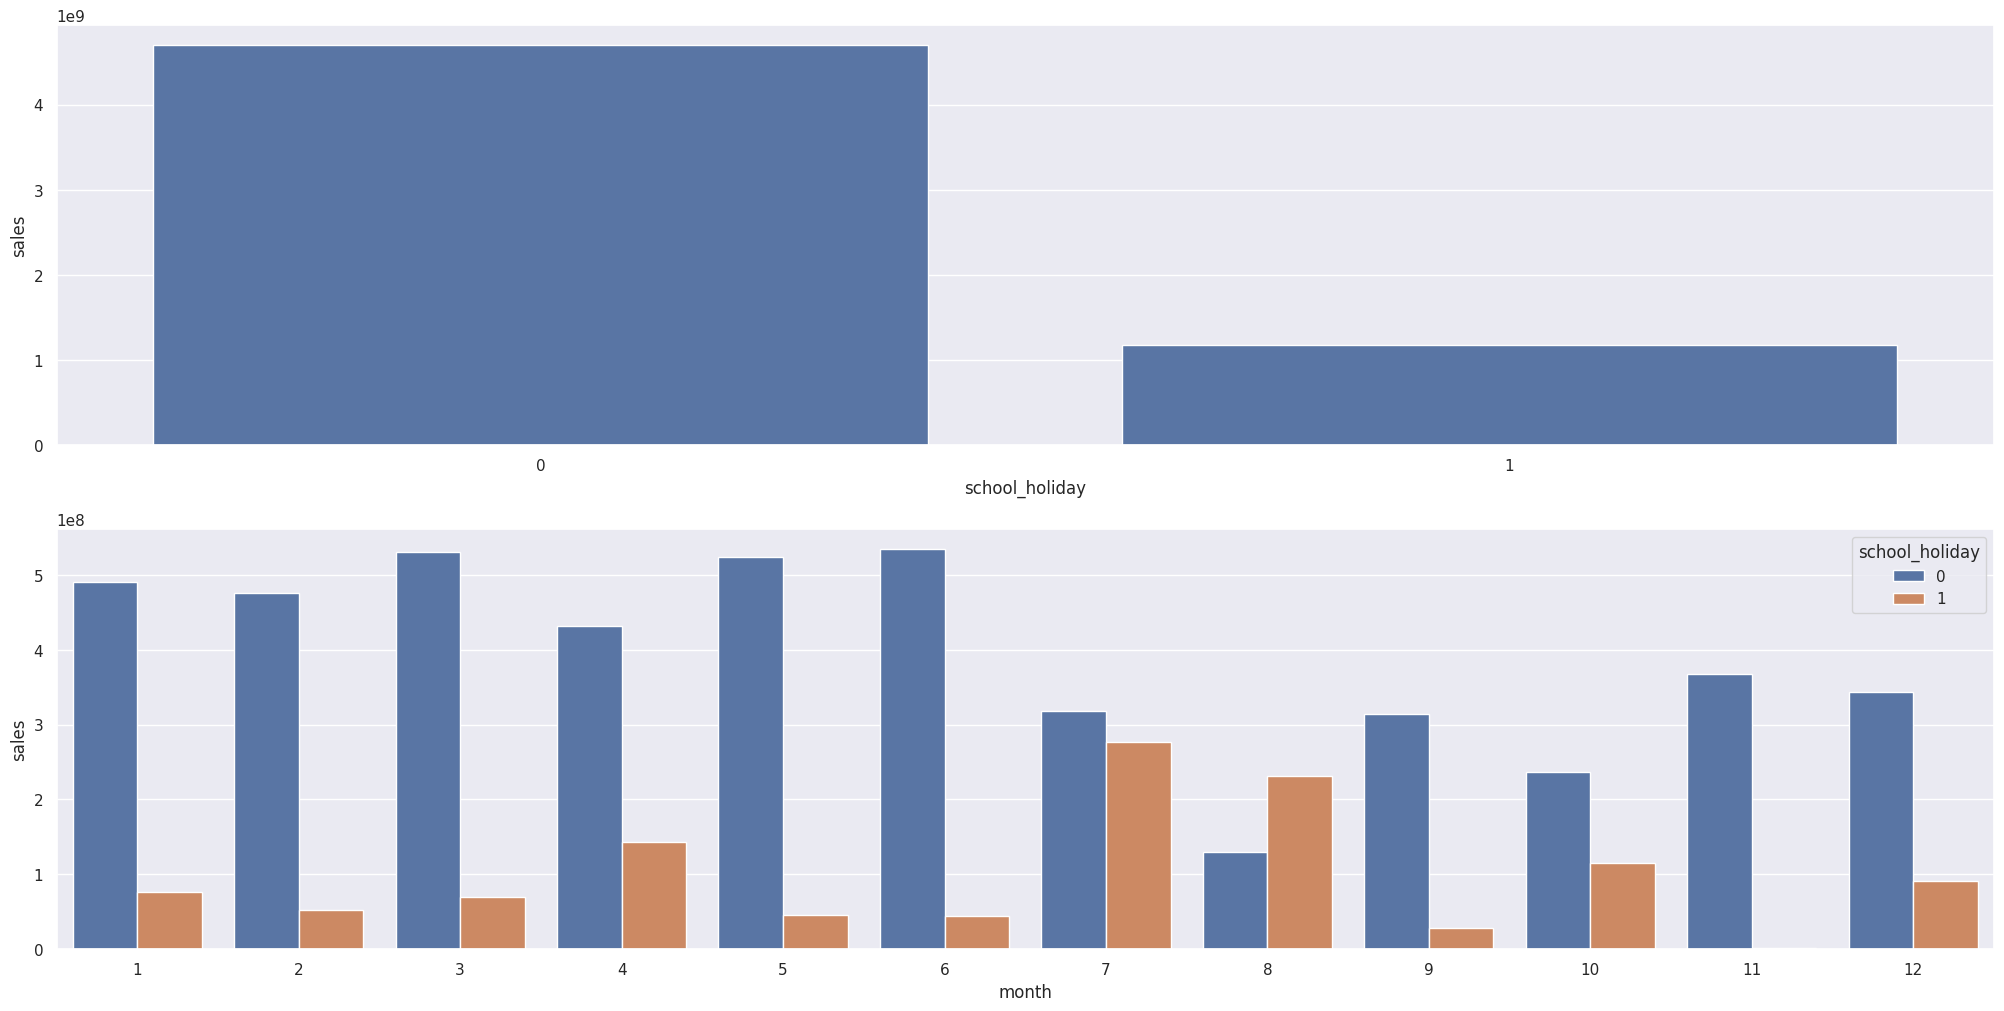

In [58]:
# Lojas deveriam vender menos durante os feriados escolares
# VERDADEIRA - Lojas vendem menos durante os feriados escolares, exceto os meses de Julho e Agosto

aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux1)

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2)

## 4.3 Análise Multivariada

### 4.3.1 Numerical Attributes

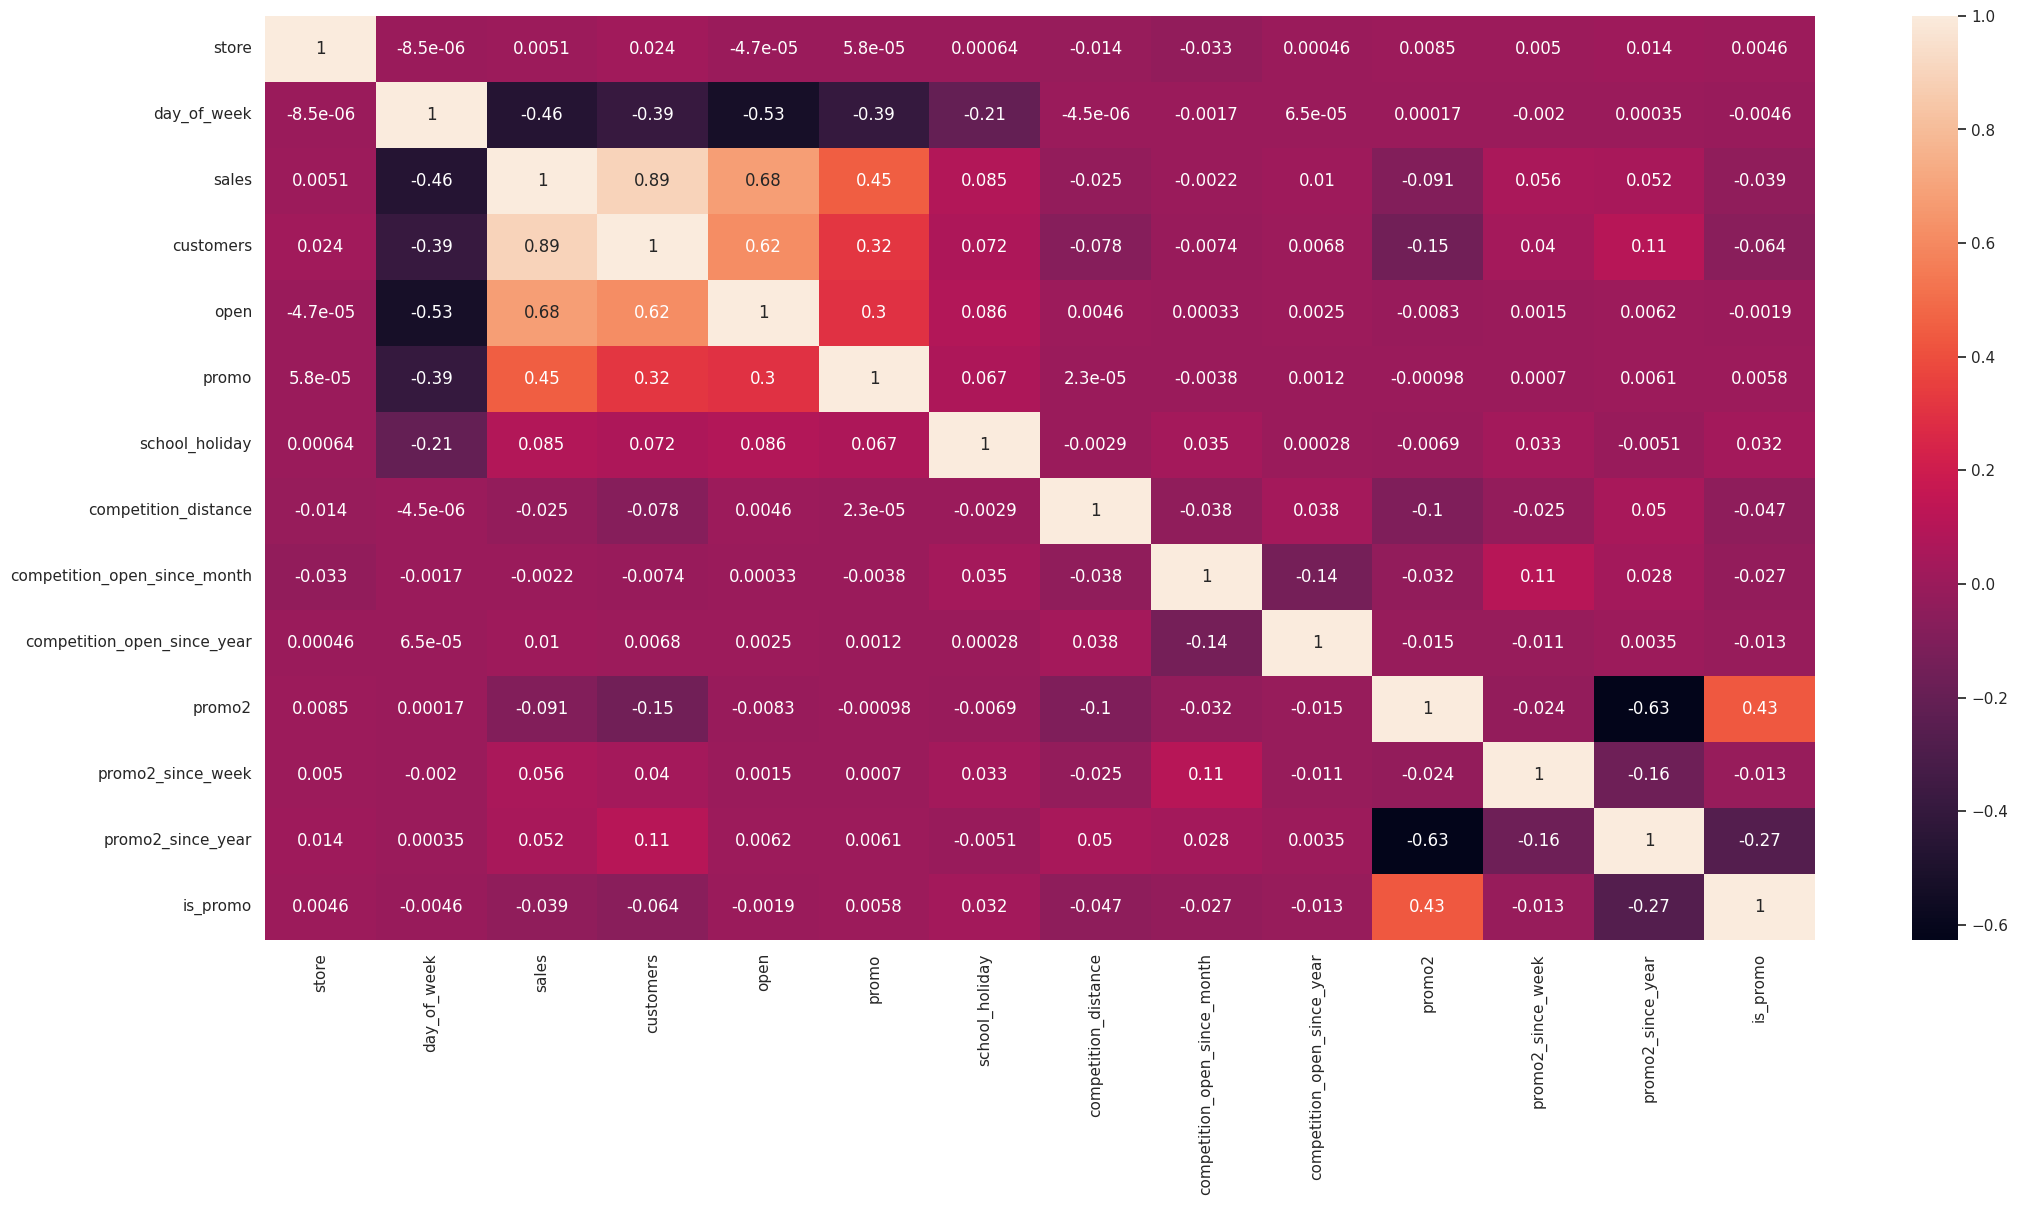

In [59]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

<Axes: >

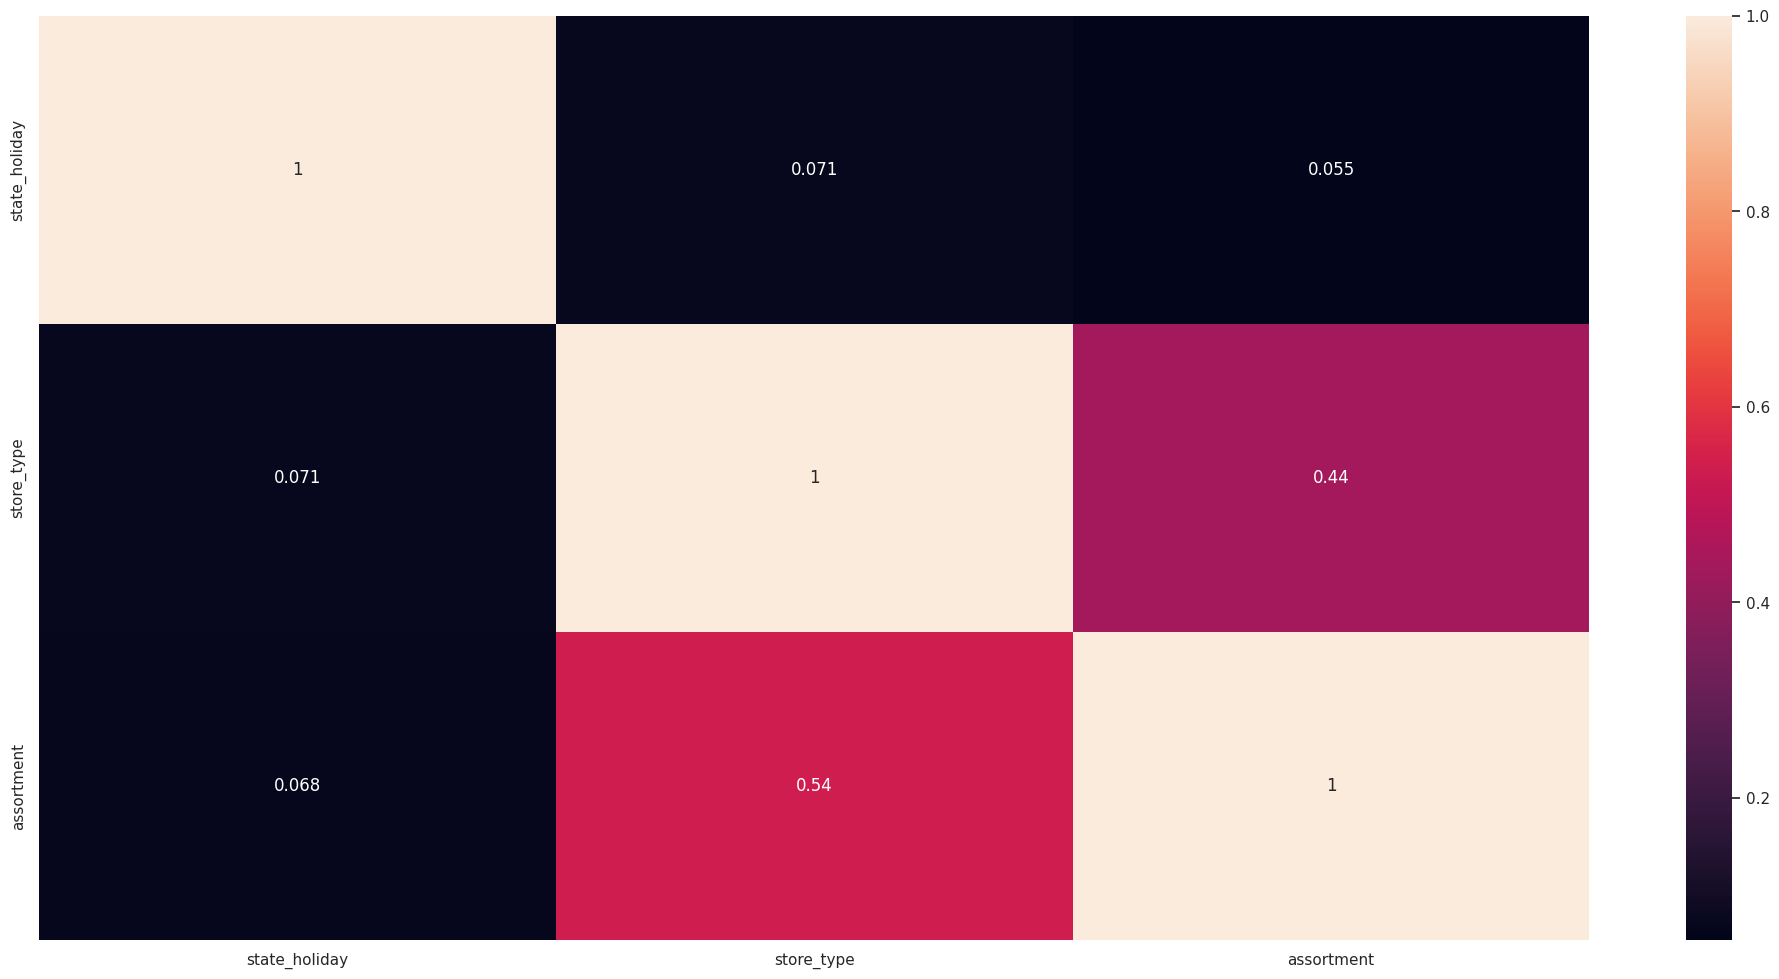

In [60]:
#Only categorical data
a = df4.select_dtypes( include= 'object')


# Calculate Cramer V
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# Final dataset
d = pd.DataFrame(  {'state_holiday': [a1, a2, a3],
                'store_type': [a4, a5, a6],
                'assortment': [a7, a8, a9]
            })

d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

# 5.0 Data Preparation

In [119]:
df5 = df4.copy()

## 5.1 Normalização

Ao verificar a seção 4.1.2 é possivel perceber que não temos nenhum valor que segue uma distribuição normal, logo não será feita nenhuma normalização nos dados.

## 5.2 Rescaling

In [62]:
# Min-Max Scaler: Mantem a forma, contudo é sensivel a outliers

# Robust Scaler: Mais robusto a outliers


In [117]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

# competition time month

df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

# promo time week

df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

#year

df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

## 5.3 Transformation

### 5.3.1 Encoding

In [120]:
#state_holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl', 'wb'))

#assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [65]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [66]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * ( 2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * ( 2. * np.pi/12)))
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * ( 2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * ( 2. * np.pi/30)))
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * ( 2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * ( 2. * np.pi/52)))
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * ( 2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * ( 2. * np.pi/7)))

# 6.0 Feature Selection

In [67]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [68]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop(cols_drop, axis=1)

In [69]:
df6[['store', 'date']].groupby('store').max().reset_index()[ 'date'][0] - datetime.timedelta(days= 7*6)

Timestamp('2015-06-19 00:00:00')

In [70]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [71]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()

##define RandomForestRegressor

#rf = RandomForestRegressor (n_jobs=-1)

##define boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

### 6.2.1 Best Features From Boruta

In [72]:
#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selection

In [73]:
cols_selected_boruta =[
        'store',
        'promo',
        'store_type',
        'assortment',
        'competition_distance',
        'competition_open_since_month',
        'competition_open_since_year',
        'promo2',
        'promo2_since_week',
        'promo2_since_year',
        'competition_time_month',
        'promo_time_week',
        'month_cos',
        'month_sin',
        'day_sin',
        'day_cos',
        'week_of_year_cos',
        'week_of_year_sin',
        'day_of_week_sin',
        'day_of_week_cos'
        ]

# columns to add
feat_to_add = ['date', 'sales']

#final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [74]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos']

In [75]:
#cols_not_selected_boruta

# 7.0 Machine Learning Modeling

In [76]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train [cols_selected_boruta_full]


## 7.1 Average Model

In [77]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performace
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model

In [78]:
# model
lr = LinearRegression().fit( x_train, y_train )
# prediction
yhat_lr = lr.predict( x_test )
# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [79]:
lr_result_cv = cross_validation (x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [80]:
# model
lrr = Lasso( alpha=0.01).fit( x_train, y_train )
# prediction
yhat_lrr = lrr.predict( x_test )
# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1(yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451735


### 7.3.1 Lasso - Cross Validation

In [81]:
lrr_result_cv = cross_validation (x_training, 5, 'Lasso', lrr, verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [82]:
# model
rf = RandomForestRegressor( n_estimators= 100, n_jobs=-1, random_state=42).fit( x_train, y_train )
# prediction
yhat_rf = rf.predict( x_test )
# performance
rf_result = ml_error( 'Random Forest Regressor', np.expm1( y_test ), np.expm1(yhat_rf ) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.154927,0.099863,1010.417753


### 7.4.1 Random Forest Regressor - Cross Validation

In [83]:
rf_result_cv = cross_validation (x_training, 5, 'Random Forest Regressor', rf, verbose=False)
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,840.04 +/- 220.0,0.12 +/- 0.02,1261.15 +/- 323.09


## 7.5 XGBoost Regressor

In [84]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100,
                              eta=0.01,
                              max_depth=10,
                              subsample=0.7,
                              colsample_bytree=0.9).fit( x_train, y_train )
# prediction
yhat_xgb = model_xgb.predict( x_test )
# performance
xgb_result = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1(yhat_xgb ) )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1686.960298,0.250482,2465.897192


### 7.5.1 XGBoost Regressor - Cross Validation

In [85]:
xgb_result_cv = cross_validation (x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1857.67 +/- 292.27,0.25 +/- 0.01,2686.2 +/- 436.3


## 7.6 Compare Model's Performace

### 7.6.1 Single Performace

In [86]:
modelling_result = pd.concat ([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.154927,0.099863,1010.417753
0,Average Model,1354.800353,0.455051,1835.135542
0,XGBoost Regressor,1686.960298,0.250482,2465.897192
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704880,0.289106,2744.451735


### 7.6.2 Real Performace - Cross Validation

In [87]:
modelling_result_cv = pd.concat ([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,840.04 +/- 220.0,0.12 +/- 0.02,1261.15 +/- 323.09
0,XGBoost Regressor,1857.67 +/- 292.27,0.25 +/- 0.01,2686.2 +/- 436.3


# 8.0 Hyperparameter Finetuning

## 8.1 Random Search

In [88]:
# param = {
#         'n_estimators': [1500, 1700, 2500, 3000, 3500],
#         'eta': [0.01, 0.03],
#         'max_depth': [3, 5, 9],
#         'subsample': [0.1, 0.5, 0.7],
#         'colsample_bytree': [0.3, 0.7, 0.9],
#         'min_child_weight': [3, 8 ,15]}

# MAX_EVAL = 10

In [89]:
# final_result = pd.DataFrame()
# for i in range (MAX_EVAL):
#   # choose values for parameters randomly
#   hp = {k: random.sample (v, 1)[0] for k, v in param.items()}
#   print (hp)
#   # model
#   model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                 n_estimators=hp['n_estimators'],
#                                 eta=hp['eta'],
#                                 max_depth=hp['max_depth'],
#                                 subsample=hp['subsample'],
#                                 colsample_bytree=hp['colsample_bytree'],
#                                 min_child_weight=hp['min_child_weight']).fit( x_train, y_train )

#   # performance
#   result = cross_validation (x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
#   final_result = pd.concat([final_result, result])
# final_result

## 8.2 Final Model

In [90]:
param_tunned = {
        'n_estimators': 2500,
        'eta': 0.03,
        'max_depth': 9,
        'subsample': 0.7,
        'colsample_bytree': 0.3,
        'min_child_weight': 8}

In [91]:
# model
model_xgb_tunned = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=param_tunned['n_estimators'],
                              eta=param_tunned['eta'],
                              max_depth=param_tunned['max_depth'],
                              subsample=param_tunned['subsample'],
                              colsample_bytree=param_tunned['colsample_bytree'],
                              min_child_weight=param_tunned['min_child_weight']).fit( x_train, y_train )

# prediction
yhat_xgb_tuned = model_xgb_tunned.predict( x_test )


# performance
xgb_result_tunned  = ml_error( 'XGBoost Regressor Tunned', np.expm1( y_test ), np.expm1(yhat_xgb_tuned ) )
xgb_result_tunned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor Tunned,660.478134,0.096488,959.17392


In [92]:
pickle.dump( model_xgb_tunned, open ( 'model_rossmann.pkl', 'wb'))

# 9.0 Traduçao e Interpretação do Erro

In [93]:
df9 = X_test [cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business Performace

In [94]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_error( x['sales'], x['predictions'])).reset_index().rename (columns={0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'])).reset_index().rename (columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge (df9_aux1, df9_aux2, how= 'inner', on='store')
df92 = pd.merge(df91, df9_aux3, how= 'inner', on='store')

# Scenarios
df92[ 'worst_scenario' ] = df92['predictions'] - df92['MAE']
df92[ 'best_scenario' ] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92 [['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [95]:
df92.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,162608.156250,162302.257964,162914.054536,305.898286,0.068591
1,2,181275.843750,180912.147560,181639.539940,363.696190,0.076467
2,3,261874.265625,261357.193749,262391.337501,517.071876,0.072979
3,4,329232.281250,328060.466309,330404.096191,1171.814941,0.112336
4,5,172130.218750,171763.943900,172496.493600,366.274850,0.082568


<Axes: xlabel='store', ylabel='MAPE'>

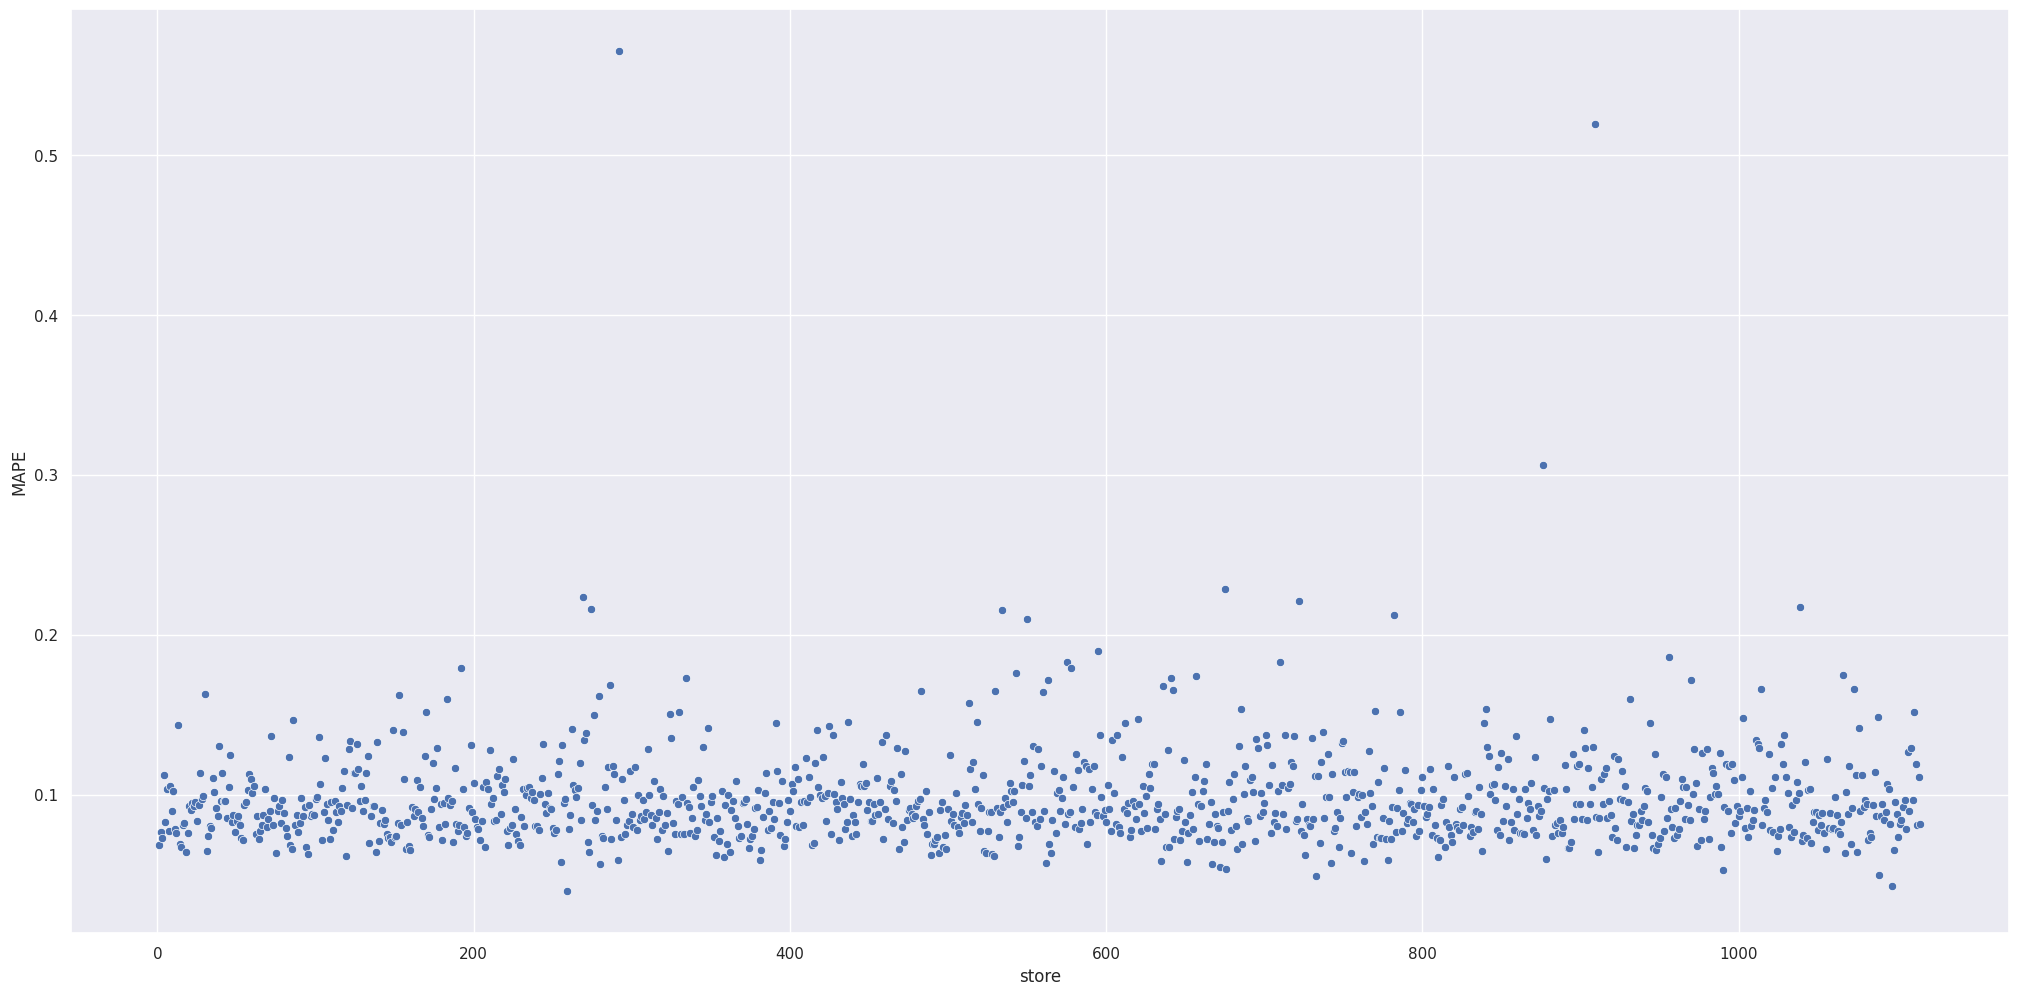

In [96]:
sns.scatterplot (x='store', y='MAPE', data=df92)

## 9.2 Total Performace

In [97]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum(x), axis=0).reset_index().rename( columns={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$285,244,608.00"
1,worst_scenario,"R$284,504,127.24"
2,best_scenario,"R$285,985,138.35"


## 9.3 Machine Learning Performance

In [98]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

In [99]:
df9[ 'error'].head()

,error
0,-241.424316
1,274.975586
2,-797.871094
3,3035.643555
4,-1340.449219


<Axes: xlabel='predictions', ylabel='error'>

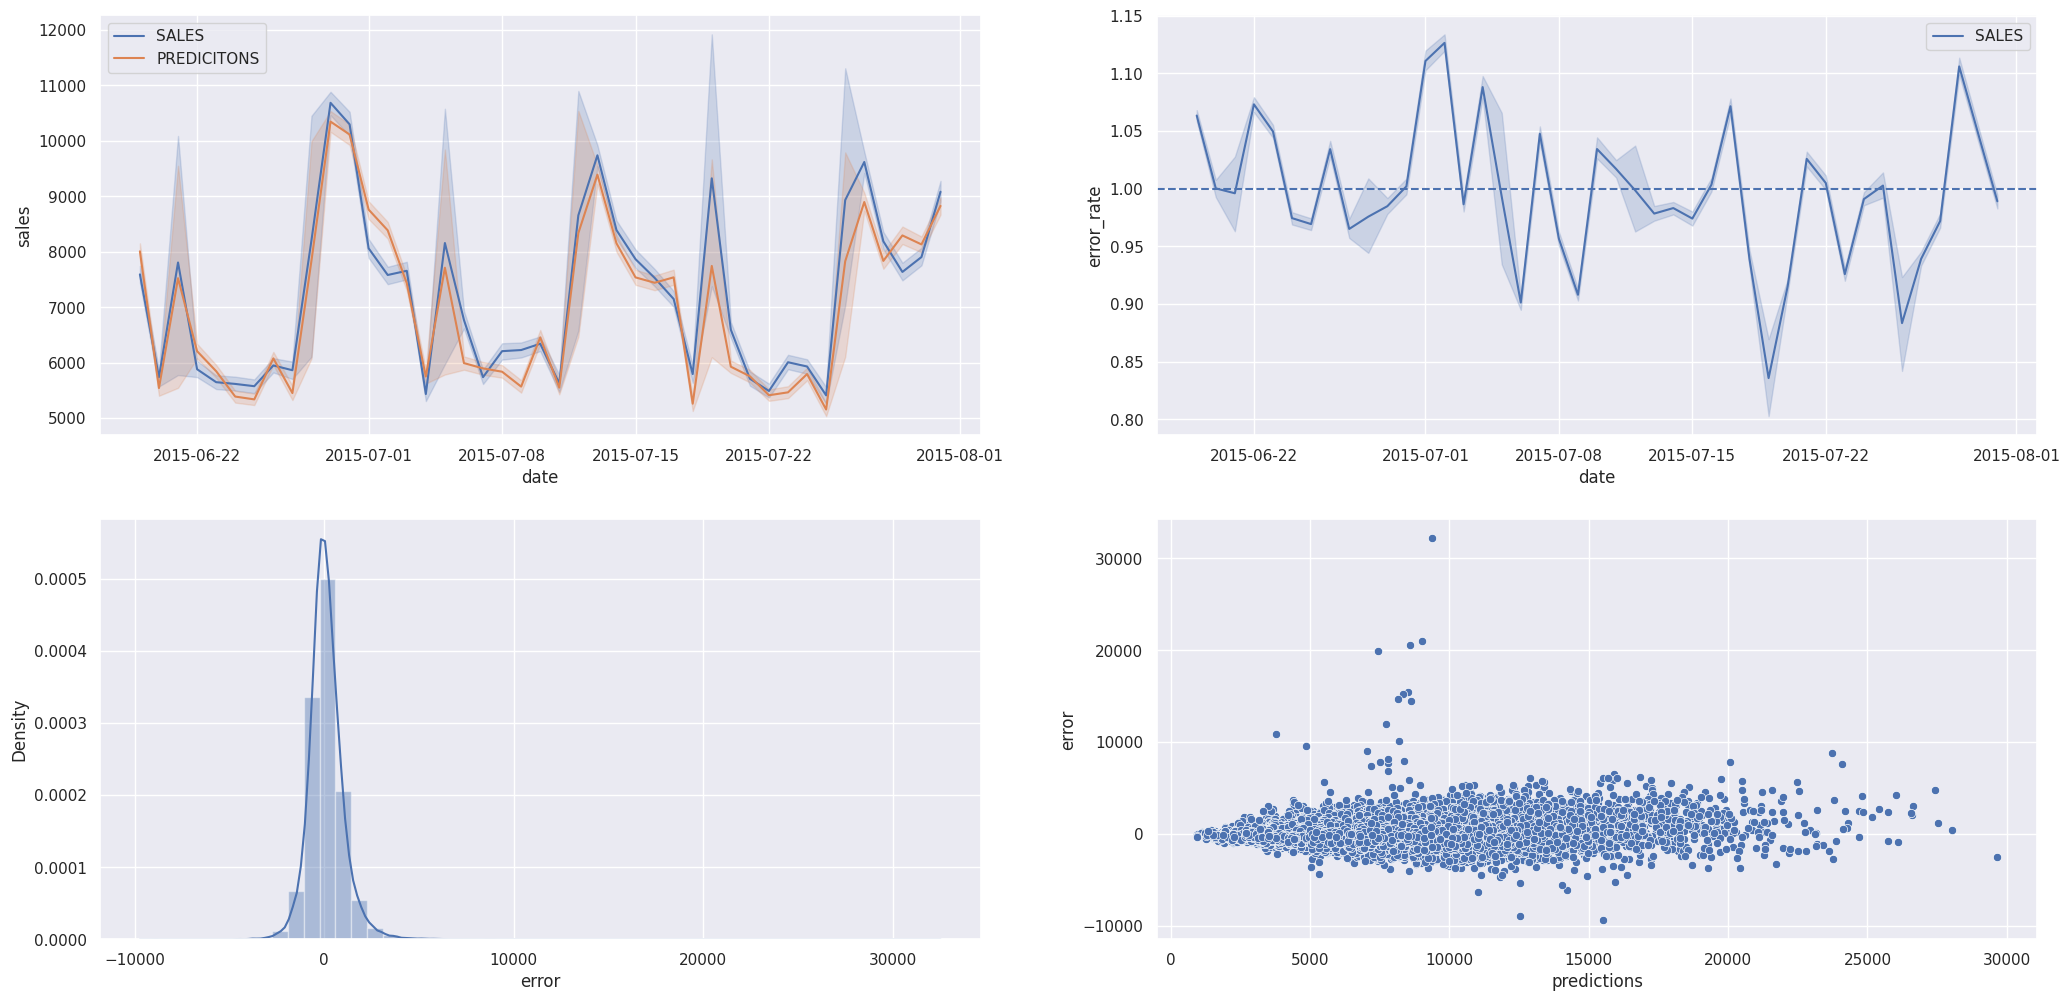

In [100]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICITONS')

plt.subplot( 2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9, label='SALES')
plt.axhline(1, linestyle= '--')

plt.subplot( 2,2,3)
sns.distplot(df9['error'])

plt.subplot( 2,2,4)
sns.scatterplot(x= df9['predictions'], y= df9['error' ])


# 10.0 Deploy Model to Production

In [101]:
# Save Trained Model
pickle.dump( model_xgb_tunned, open( 'model/model_rossmann.pkl', 'wb'))

## 10.1 Rossmann Class

In [133]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann (object):
  def __init__ (self):
    self.home_path = '/content/ds_producao/'
    self.competition_distance_scaler    = pickle.load( open(self.home_path  + 'parameter/competition_distance_scaler.pkl', 'rb'))
    self.competition_time_month_scaler  = pickle.load( open(self.home_path  + 'parameter/competition_time_month_scaler.pkl', 'rb'))
    self.promo_time_week_scaler         = pickle.load( open(self.home_path  + 'parameter/promo_time_week_scaler.pkl', 'rb'))
    self.year_scaler                    = pickle.load( open(self.home_path  + 'parameter/year_scaler.pkl', 'rb'))
    self.store_type_scaler              = pickle.load( open(self.home_path  + 'parameter/store_type_scaler.pkl', 'rb'))

  def data_cleaning(self, df1):
    # Rename Columns
    cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday',
                'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear',
                'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

    snakecase = lambda x: inflection.underscore( x )

    cols_new = list (map (snakecase, cols_old))

    # rename
    df1.columns = cols_new

    df1['date'] = pd.to_datetime( df1['date'])

    ## 1.5 Fillout NA
    # competition_distance

    df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan ( x ) else x)

    # competition_open_since_month

    df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

    # competition_open_since_year

    df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

    # promo2_since_week

    df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

    # promo2_since_year

    df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

    # promo_interval

    month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

    df1['promo_interval'].fillna(0, inplace=True)

    df1['month_map'] = df1['date'].dt.month.map( month_map)

    df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',') else 0, axis=1)


    df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
    df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

    df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
    df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

    return df1

  def feature_engineering (self, df2):
    # year

    df2['year'] = df2['date'].dt.year

    # month

    df2['month'] = df2['date'].dt.month

    # day

    df2['day'] = df2['date'].dt.day

    # week of year

    df2['week_of_year'] = df2['date'].dt.isocalendar().week

    # year of week

    df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

    # competition since

    df2['competition_since'] = df2.apply(lambda x: datetime.datetime ( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1) , axis= 1)
    df2['competition_time_month'] = ((df2['date'] - df2[ 'competition_since'])/30).apply(lambda x: x.days).astype(int)

    # promo since

    df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
    df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))

    df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply( lambda x: x.days).astype(int)

    # assortment

    df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x=='b' else 'extended')

    # state holiday

    df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')
    ## 3.1 Filtragem das linhas
    df2 = df2[df2['open'] != 0]
    ## 3.2 Seleção das Colunas
    cols_drop = ['open', 'promo_interval', 'month_map']

    df2 = df2.drop(cols_drop, axis=1)

    return df2

  def data_preparation (self, df5):
    ## 5.2 Rescaling
    # competition_distance
    df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)


    # competition time month
    df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)


    # promo time week
    df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

    #year
    df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

    ### 5.3.1 Encoding
    #state_holiday - One Hot Encoding
    df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

    #store_type - Label Encoding
    df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

    #assortment - Ordinal Encoding
    assortment_dict = {'basic': 1, 'extra': 2, 'extended':3}
    df5['assortment'] = df5['assortment'].map(assortment_dict)

    ### 5.3.3 Nature Transformation
    # month
    df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * ( 2. * np.pi/12)))
    df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * ( 2. * np.pi/12)))
    # day
    df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * ( 2. * np.pi/30)))
    df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * ( 2. * np.pi/30)))
    # week of year
    df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * ( 2. * np.pi/52)))
    df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * ( 2. * np.pi/52)))
    # day of week
    df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * ( 2. * np.pi/7)))
    df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * ( 2. * np.pi/7)))

    cols_selected_ =['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
        'month_cos', 'month_sin', 'day_sin', 'day_cos', 'week_of_year_cos', 'week_of_year_sin', 'day_of_week_sin', 'day_of_week_cos']

    return df5 [cols_selected_ ]


  def get_prediction (self, model, original_data, test_data):
    #prediction
    pred = model.predict(test_data)

    #join pred into the original data
    original_data['prediction'] = np.expm1(pred)

    return original_data.to_json(orient='records', date_format='iso')

## 10.2 API Handler

In [ ]:
import pickle
import pandas as pd


from flask              import Flask, request, Response
from rossmann.Rossmann  import Rossmann

# loading model
model = pickle.load( open( '/content/ds_producao/model/model_rossmann.pkl', 'rb'))


# initialize API
app = Flask ( __name__)



@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
  test_json = request.get_json()

  if test_json:
    if isinstance(test_json, dict): # Unique exemple
      test_raw = pd.DataFrame(test_json, index=[0])

    else: # Multiple examples
      test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

    # Instantiate Rossmann class
    pipeline = Rossmann()

    # data cleaning
    df1 = pipeline.data_cleaning(test_raw)

    # feature engineering
    df2 = pipeline.feature_engineering(df1)

    # data preparation
    df3 = pipeline.data_preparation(df2)

    # prediciton
    df_response = pipeline.get_prediction(model, test_raw, df3)

    return df_response

  else:
    return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
  app.run('0.0.0.0')

## 10.3 API Tester

In [3]:
import json
import requests

In [4]:
# loading dataset

df10 = pd.read_csv('D:/Comunidade DS/Portifólio de Projetos/repos/ds_producao/datasets/test.csv')

In [8]:
# merge test dataset + store

df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin([25, 30, 27])]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[-df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [9]:
# convert Dataframe to json

data = json.dumps(df_test.to_dict(orient = 'records'))

In [10]:
# API Call

url = 'https://rossmann-predictions-fzqi.onrender.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data
r= requests.post(url, data=data, headers=header)
print('Status Code{}'.format(r.status_code))

Status Code200


In [11]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [12]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()
for i in range (len(d2)):
  print('Store number {} will sell R${:,.2f} in the next 6 weeeks.'.format(
      d2.loc[i, 'store'],
      d2.loc[i, 'prediction']
  ))

Store number 25 will sell R$333,906.02 in the next 6 weeeks.
Store number 27 will sell R$234,604.79 in the next 6 weeeks.
Store number 30 will sell R$226,900.41 in the next 6 weeeks.
